**<center><h1>T-SNE Notebook</h1></center>**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import FenicsATL as FATL
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

from multiprocessing import Process


Loading BokehJS ...

# **I. DATA INITIALIZATION**

I.2 FENICS 02

In [3]:
irrad = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025,101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
LTT_id = [29,30,31,32,33,34,35,36,37,38,39,40,1041,1042,1043,1044,1045,1046,1047]
All = irrad + LTT_id

In [4]:
FENICS2 = FATL.FenicsVers_filter(FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS2_data.json'),irrad)

FastFeaturesToDrop = [("NoiseHG","Mean"),("NoiseHG","Mu"),
                      ("NoiseHGIG1","Mean"),("NoiseHGIG1","Mu"),
                      ("NoiseHGIG2","Mean"),("NoiseHGIG2","Mu"),
                      ("NoiseHGIG6","Mean"),("NoiseHGIG6","Mu"),
                      ("NoiseLG","Mean"),("NoiseLG","Mu"),
                      ("NoiseLGIG1","Mean"),("NoiseLGIG1","Mu"),
                      ("NoiseLGIG2","Mean"),("NoiseLGIG2","Mu"),
                      ("NoiseLGIG6","Mean"),("NoiseLGIG6","Mu")]

# FENICS2 = FENICS2[FENICS2.Board.burnTime.notna()]

# temp_allindex = []
# for id in FENICS2.Board.id.unique() :
#     temp_index = FENICS2[FENICS2.Board.id == id][FENICS2.Board.channel == FENICS2[FENICS2.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index
    
# FENICS2 = FENICS2.loc[temp_allindex]
FENICS2 = FENICS2[(FENICS2.Board.StatusFast != -1) | (FENICS2.Board.StatusSlow != -1)]

Fast2 = FATL.FenicsTestTable(FENICS2,'fast')
Slow2 = FATL.FenicsTestTable(FENICS2,'slow')


# Slow2 = FATL.Normalizer(Slow2)
# Fast2 = FATL.Normalizer(Fast2)

for feature in FastFeaturesToDrop:
    Fast2 = Fast2.drop(feature, axis=1) 

slow2_index = Slow2.index

Slow2.dropna(subset=[('Gain0','Linearity','SlopeLin'),('Gain1','Linearity','SlopeLin'),('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin'),
                     ('Gain0','Linearity','ConstLin'),('Gain1','Linearity','ConstLin'),('Gain3','Linearity','ConstLin'),('Gain4','Linearity','ConstLin'),('Gain5','Linearity','ConstLin'),], inplace=True)
Slow2.dropna(inplace=True,axis=1)
Fast2.drop(index=slow2_index.difference(Slow2.index), inplace=True)
FENICS2.drop(index=slow2_index.difference(Slow2.index), inplace=True)



FastSlow2 = pd.concat([Slow2, Fast2], axis=1)

In [5]:
FEN2_batch01_ids = [29,30,31,32,33,34,35,36,37,38,39,40]
FEN2_batch02_ids = [1041,1042,1043,1044,1045,1046,1047]
NIEL_ids = [101,102,103,104,105,111,112,114,115,121,122,123,124,125,131,132,133,134,135]
TID_ids = [106,107,108,109,110,116,117,118,119,120,126,127,128,129,130,136,137,138,139,140,1021,1022,1023,1024,1025]

AllFen2 = list(set(FENICS2.Board.id[(FENICS2.Board.StatusFast==0 ) | (FENICS2.Board.StatusSlow==0)])
               .union(
                set(FEN2_batch01_ids),
                set(FEN2_batch02_ids),
                set(NIEL_ids),
                set(TID_ids))
                )

AllFen2LTT = list(set(FEN2_batch01_ids).union(set(FEN2_batch02_ids)))


In [6]:
main_dir = '/users/divers/atlas/sisaid/home2/'

# **III. FENICS 2**

III.1 FENICS 02 : FAST DATA

In [7]:
CanalStatus = {
    'StatusSlow' : FENICS2.Board.StatusSlow,
    'StatusFast' :  FENICS2.Board.StatusFast
}

Normalization = [False,True]

for norm in Normalization :
    tsne_param = TSNE()
    tsne_param.fit(Fast2)

    tsne_bokeh = FATL.FenBokehTSNE(Fast2,normalize=norm,perplexity=tsne_param.perplexity,n_iter=tsne_param.n_iter,learning_rate=tsne_param.learning_rate)

    epsilon = 5
    min_samples = 2
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(tsne_bokeh.embedding)
    FENICS2[('Labels','Fast')] = dbscan.labels_

    OutputPath = main_dir+'fen2_output/t-sne/fast/HTML/'

    FATL.checkFolderAt(OutputPath)

    custom_filter = [('Combo',dict(labels_filter=irrad,
                                radio_categories=[dict(name = 'All',indexes=irrad),
                                                    dict(name = 'TID',indexes=TID_ids),
                                                    dict(name = 'NIEL',indexes=NIEL_ids),
                                                    ]))]

    tsne= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                            colors=FENICS2.Board.burnTime ,labels=FENICS2.Board.id,
                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

    tsne.plotter(plotType='histogram',filters=custom_filter,
                title=f't-SNE : FENICS02 FAST; normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity},n_iter={tsne_param.n_iter},learning_rate={tsne_param.learning_rate}')

    # tsne.save_as_html(path=OutputPath,filename=f'FEN2_FAST_t-SNE_perplexity_{tsne_param.perplexity}_wburn_normed_{tsne_bokeh.normed}.html')


    for status in CanalStatus.keys() :
        Cluster_Filtred= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                                            colors=CanalStatus[status] ,labels=FENICS2.Board.id,
                                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

        Cluster_Filtred.plotter(plotType='histogram',filters=custom_filter,
                                title=f't-SNE : FENICS02 FAST (Fail : {status}); normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity}')
        # Cluster_Filtred.save_as_html(path=OutputPath,filename=f'FEN2_FAST_t-SNE_perplexity_{tsne_param.perplexity}_wSStatusSlow_normed_{tsne_bokeh.normed}.html')


III.2 FENICS 02 : SLOW DATA

In [8]:
Slow2_filtred = pd.DataFrame()
Slow2_filtred = Slow2
removed_features_lienarity = ['DACforPed']
Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow2_filtred = Slow2_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [9]:
tsne_param = TSNE()
tsne_param.fit(Slow2_filtred)

for norm in Normalization :
    tsne_bokeh = FATL.FenBokehTSNE(Slow2_filtred,normalize=norm,perplexity=tsne_param.perplexity,n_iter=tsne_param.n_iter,learning_rate=tsne_param.learning_rate)

    epsilon = 3.2
    min_samples = 5
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(tsne_bokeh.embedding)
    FENICS2[('Labels','Slow')] = dbscan.labels_

    OutputPath = main_dir+'fen2_output/t-sne/slow/HTML/'

    FATL.checkFolderAt(OutputPath)

    tsne= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                            colors=FENICS2.Board.burnTime ,labels=FENICS2.Board.id,
                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

    tsne.plotter(plotType='histogram',filters=custom_filter,
                title=f't-SNE : FENICS02 SLOW; normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity},n_iter={tsne_param.n_iter},learning_rate={tsne_param.learning_rate}')

    # tsne.save_as_html(path=OutputPath,filename=f'FEN2_SLOW_t-SNE_perplexity_{tsne_param.perplexity}_wburn_normed_{tsne_bokeh.normed}.html')


    for status in CanalStatus.keys() :
        Cluster_Filtred= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                                            colors=CanalStatus[status] ,labels=FENICS2.Board.id,
                                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

        Cluster_Filtred.plotter(plotType='histogram',filters=custom_filter,
                                title=f't-SNE : FENICS02 SLOW (Fail : {status}); normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity}')



    # Cluster_Filtred.save_as_html(path=OutputPath,filename=f'FEN2_SLOW_t-SNE_perplexity_{tsne_param.perplexity}_wStatusSlow_normed_{tsne_bokeh.normed}.html')


III.3 FENICS 02 : FAST + SLOW DATA

In [11]:
FastSlow2_filtred = pd.concat([Slow2_filtred, Fast2], axis=1)

In [12]:
tsne_param = TSNE()
tsne_param.fit(FastSlow2_filtred)

for norm in Normalization :
    tsne_bokeh = FATL.FenBokehTSNE(FastSlow2_filtred,normalize=norm,perplexity=20,n_iter=200000,learning_rate=200)

    epsilon = 5
    min_samples = 2
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
    dbscan.fit(tsne_bokeh.embedding)
    FENICS2[('Labels','FastSlow')] = dbscan.labels_

    OutputPath = main_dir+'fen2_output/t-sne/fastslow/HTML/'

    FATL.checkFolderAt(OutputPath)


    tsne= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                            colors=FENICS2.Board.burnTime ,labels=FENICS2.Board.id,
                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

    tsne.plotter(plotType='histogram',filters=custom_filter,
                title=f't-SNE : FENICS02 FAST + SLOW; normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity},n_iter={tsne_param.n_iter},learning_rate={tsne_param.learning_rate}')

    # tsne.save_as_html(path=OutputPath,filename=f'FEN2_FASTSLOW_t-SNE_perplexity_{tsne_param.perplexity}_wburn_normed_{tsne_bokeh.normed}.html')


    for status in CanalStatus.keys() :
        Cluster_Filtred= FATL.FenBokehGrapher(tsne_bokeh.tsne_x,tsne_bokeh.tsne_y,FENICS2.Board.version,FENICS2.Board.burnTime,FENICS2.Board.StatusFast,FENICS2.Board.StatusSlow,
                                            colors=CanalStatus[status] ,labels=FENICS2.Board.id,
                                            tooltips=[("card","FENICS0@version @labels"),("burnTime","@burnTime"),
                                                        ("StatusFast","@StatusFast"),("StatusSlow","@StatusSlow")])

        Cluster_Filtred.plotter(plotType='histogram',filters=custom_filter,
                                title=f't-SNE : FENICS02 Fast + SLOW (Fail : {status}); normed {tsne_bokeh.normed}; t-SNE params : perplexity={tsne_param.perplexity}')
        # Cluster_Filtred.save_as_html(path=OutputPath,filename=f'FEN2_FASTSLOW_t-SNE_perplexity_{tsne_param.perplexity}_wStatusSlow_normed_{tsne_bokeh.normed}.html')


# Features comparaison

In [28]:
FENICS2 = FATL.FenicsData_read('/AtlasDisk/home2/sisaid/data/FENICS2_data.json')

FastFeaturesToDrop = [("NoiseHG","Mean"),("NoiseHG","Mu"),
                      ("NoiseHGIG1","Mean"),("NoiseHGIG1","Mu"),
                      ("NoiseHGIG2","Mean"),("NoiseHGIG2","Mu"),
                      ("NoiseHGIG6","Mean"),("NoiseHGIG6","Mu"),
                      ("NoiseLG","Mean"),("NoiseLG","Mu"),
                      ("NoiseLGIG1","Mean"),("NoiseLGIG1","Mu"),
                      ("NoiseLGIG2","Mean"),("NoiseLGIG2","Mu"),
                      ("NoiseLGIG6","Mean"),("NoiseLGIG6","Mu")]

# FENICS2 = FENICS2[FENICS2.Board.burnTime.notna()]

# temp_allindex = []
# for id in FENICS2.Board.id.unique() :
#     temp_index = FENICS2[FENICS2.Board.id == id][FENICS2.Board.channel == FENICS2[FENICS2.Board.id == id].Board.channel.value_counts().index[0]].index.tolist()
#     temp_allindex = temp_allindex + temp_index
    
# FENICS2 = FENICS2.loc[temp_allindex]
FENICS2 = FENICS2[(FENICS2.Board.StatusFast != -1) | (FENICS2.Board.StatusSlow != -1)]

Fast2 = FATL.FenicsTestTable(FENICS2,'fast')
Slow2 = FATL.FenicsTestTable(FENICS2,'slow')


# Slow2 = FATL.Normalizer(Slow2)
# Fast2 = FATL.Normalizer(Fast2)

for feature in FastFeaturesToDrop:
    Fast2 = Fast2.drop(feature, axis=1) 

slow2_index = Slow2.index

Slow2.dropna(subset=[('Gain0','Linearity','SlopeLin'),('Gain1','Linearity','SlopeLin'),('Gain3','Linearity','SlopeLin'),('Gain4','Linearity','SlopeLin'),('Gain5','Linearity','SlopeLin'),
                     ('Gain0','Linearity','ConstLin'),('Gain1','Linearity','ConstLin'),('Gain3','Linearity','ConstLin'),('Gain4','Linearity','ConstLin'),('Gain5','Linearity','ConstLin'),], inplace=True)
Slow2.dropna(inplace=True,axis=1)
Fast2.drop(index=slow2_index.difference(Slow2.index), inplace=True)
FENICS2.drop(index=slow2_index.difference(Slow2.index), inplace=True)



FastSlow2 = pd.concat([Slow2, Fast2], axis=1)

In [29]:
Slow2_filtred = pd.DataFrame()
Slow2_filtred = Slow2
removed_features_lienarity = ['DACforPed']
Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePhys'),('Gain1',  'NoisePhys'),
                                    ('Gain2',   'NoisePhys'),('Gain3',   'NoisePhys'),
                                    ('Gain4',   'NoisePhys'),('Gain5',  'NoisePhys')], axis=1) 

Slow2_filtred = Slow2_filtred.drop([('Gain0',   'NoisePosPed'),('Gain1',    'NoisePosPed'),
                                    ('Gain2',   'NoisePosPed'),('Gain3',   'NoisePosPed'),
                                    ('Gain4',   'NoisePosPed'),('Gain5',  'NoisePosPed')], axis=1) 

for feature in removed_features_lienarity :
    Slow2_filtred = Slow2_filtred.drop([('Gain0',   'Linearity',   feature),('Gain1',   'Linearity',    feature),
                                        ('Gain2',   'Linearity',    feature),('Gain3',   'Linearity',    feature),
                                        ('Gain4',   'Linearity',    feature),('Gain5',   'Linearity',    feature)], axis=1)

In [30]:

LTT = pd.DataFrame()
for id in AllFen2LTT :
    LTT = pd.concat([LTT,Slow2_filtred[FENICS2.Board.id == id]])
LTT_description = LTT.describe()

LTT['Population'] ='LTT'

TID = pd.DataFrame()
for id in TID_ids :
    TID = pd.concat([TID,Slow2_filtred[FENICS2.Board.id == id]])
TID_description = TID.describe()

TID['Population'] ='TID'

TID_passed = pd.DataFrame()
for id in TID_ids :
    TID_passed = pd.concat([TID_passed,Slow2_filtred[FENICS2.Board.StatusSlow==1][FENICS2.Board.id == id]])
TID_passed_description = TID_passed.describe()

TID_passed['Population'] ='TID_passed'

TID_failed = pd.DataFrame()
for id in TID_ids :
    TID_failed = pd.concat([TID_failed,Slow2_filtred[FENICS2.Board.StatusSlow==0][FENICS2.Board.id == id]])
    
TID_failed_description = TID_failed.describe()

TID_failed['Population'] ='TID_failed'


NIEL = pd.DataFrame()
for id in NIEL_ids :
    NIEL = pd.concat([NIEL,Slow2_filtred[FENICS2.Board.id == id]])
NIEL_description = NIEL.describe()

NIEL['Population'] ='NIEL'

NIEL_passed = pd.DataFrame()
for id in NIEL_ids :
    NIEL_passed = pd.concat([NIEL_passed,Slow2_filtred[FENICS2.Board.StatusSlow==1][FENICS2.Board.id == id]])
NIEL_passed_description = NIEL_passed.describe()

NIEL_passed['Population'] ='NIEL_passed'

NIEL_failed = pd.DataFrame()
for id in NIEL_ids :
    NIEL_failed = pd.concat([NIEL_failed,Slow2_filtred[FENICS2.Board.StatusSlow==0][FENICS2.Board.id == id]])
NIEL_failed_description = NIEL_failed.describe()

NIEL_failed['Population'] ='NIEL_failed'


allpopulations = pd.concat([LTT, NIEL, NIEL_passed, NIEL_failed,TID, TID_passed, TID_failed], axis=0)

allpopulations['Population_id'],_=pd.factorize(allpopulations['Population'])
# comparaison = NIEL_description.compare(LTT_description)
# comparaison
# difference = {}

# for column in failed_data.columns :
#     difference[column] = comparaison[column].self - comparaison[column].other
    
# difference = pd.DataFrame(difference)
# difference

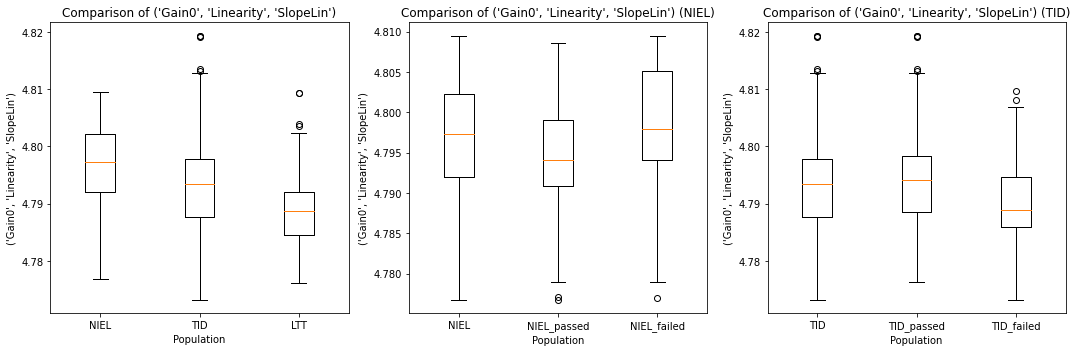

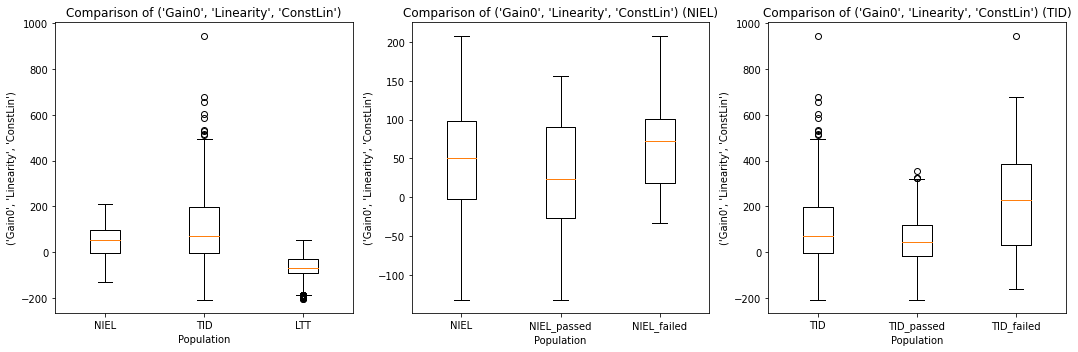

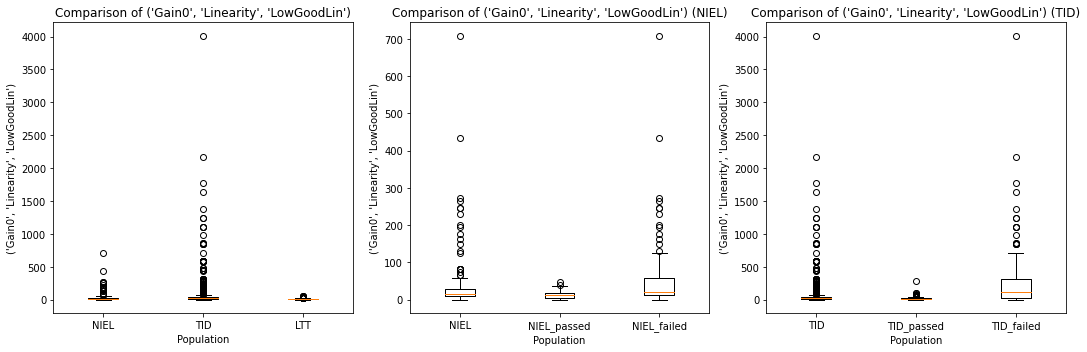

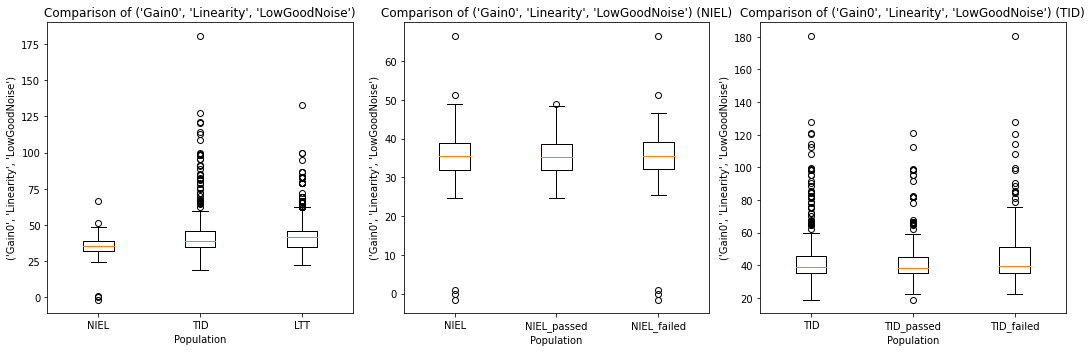

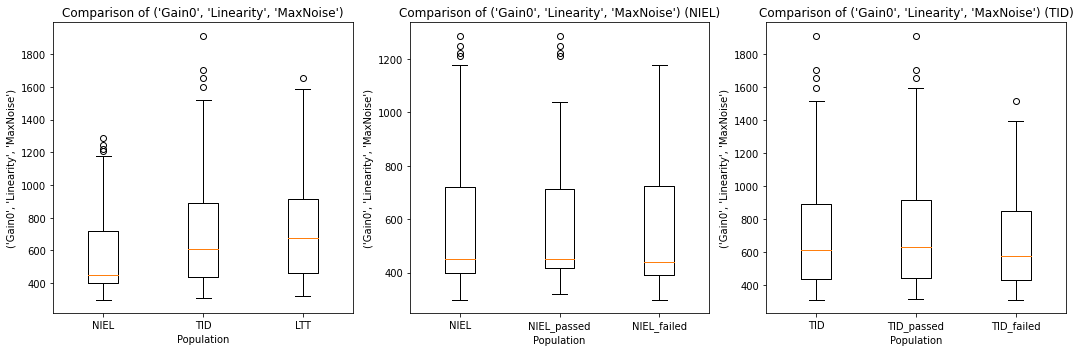

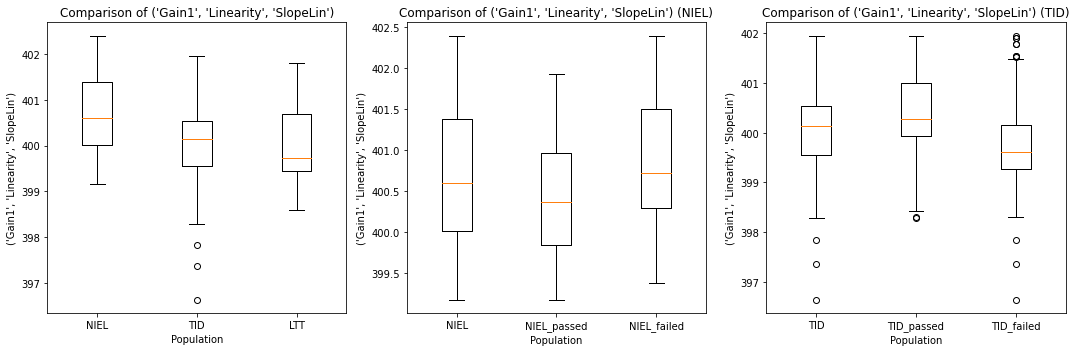

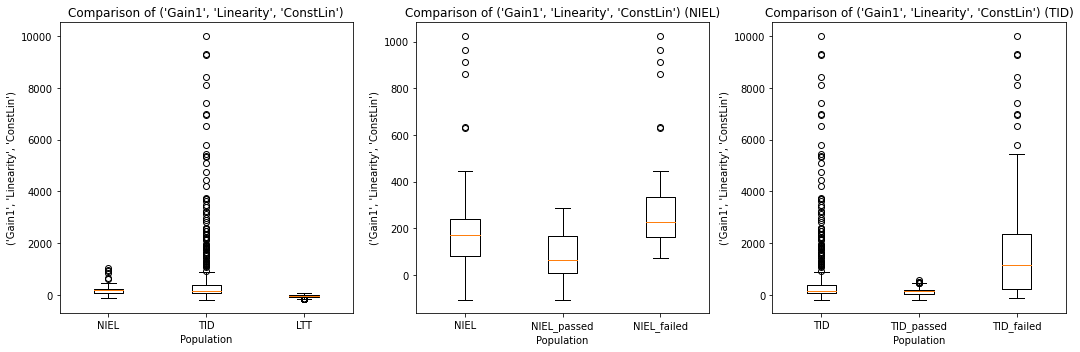

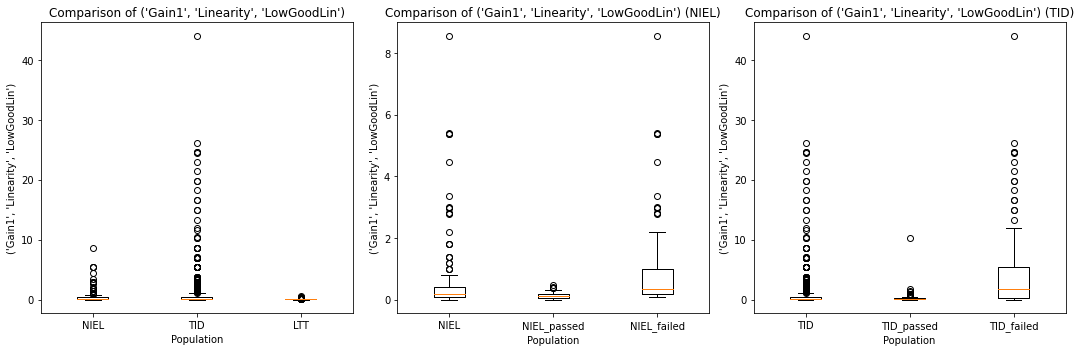

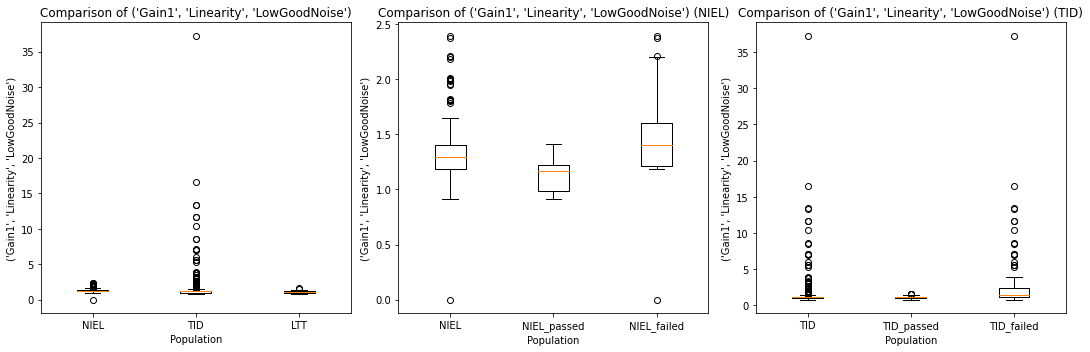

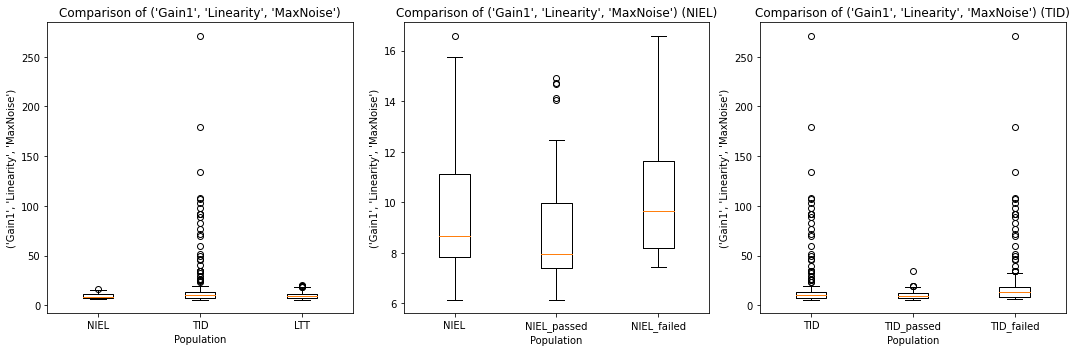

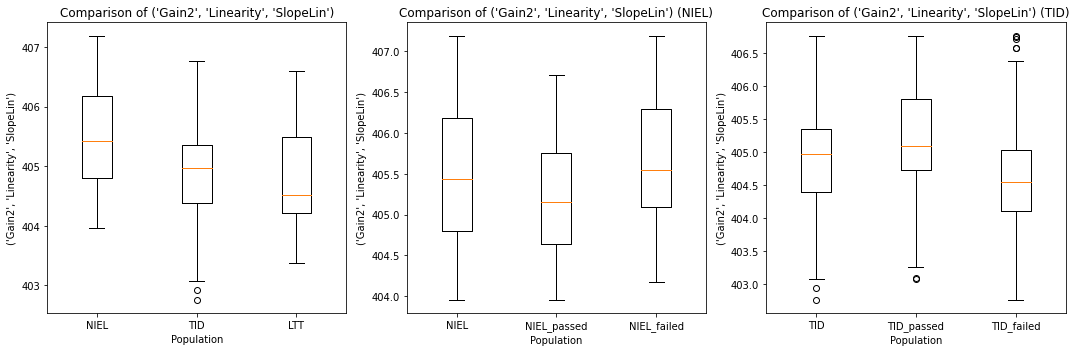

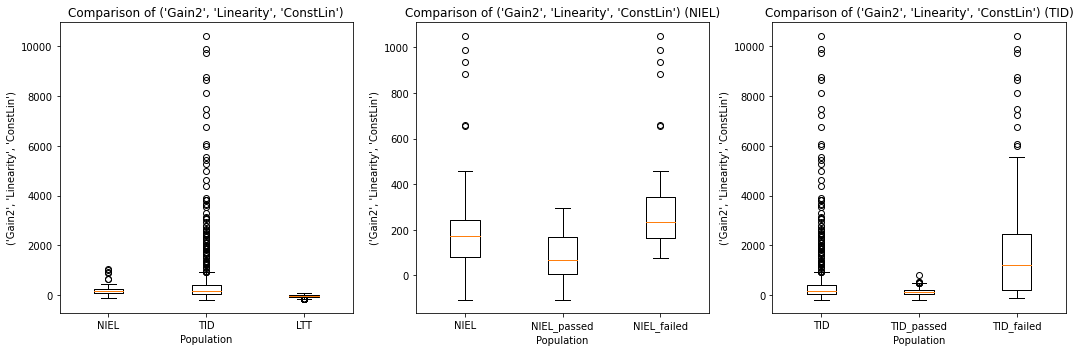

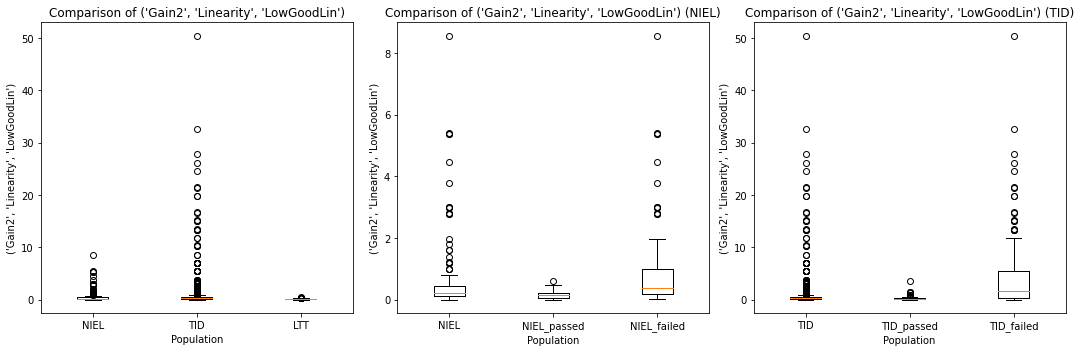

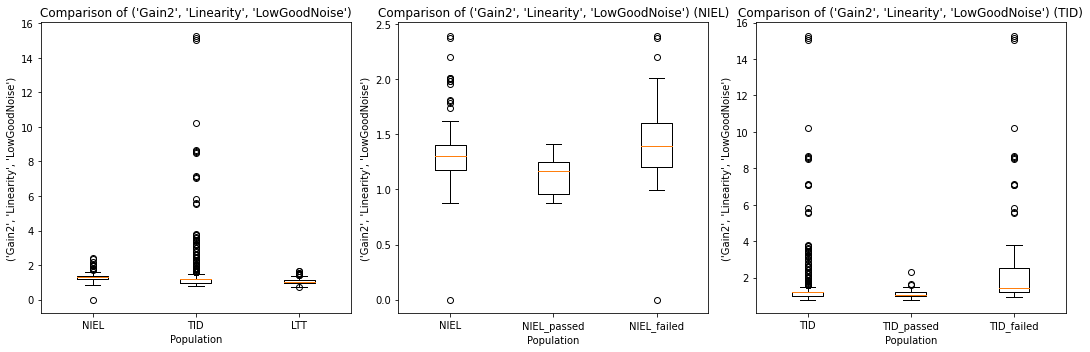

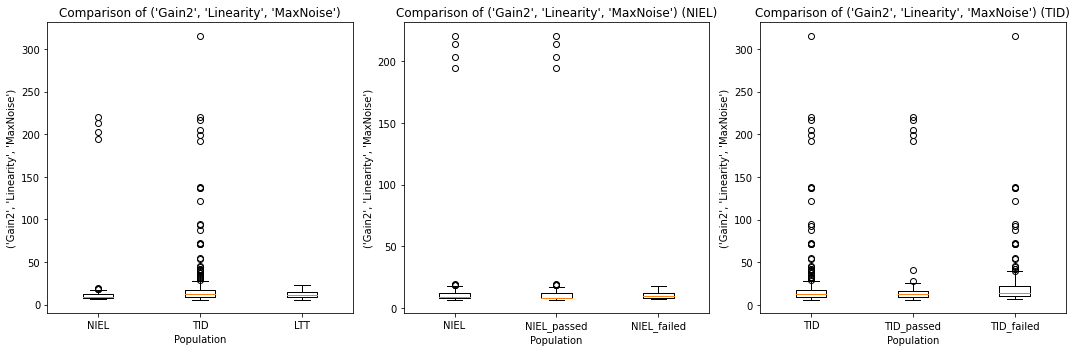

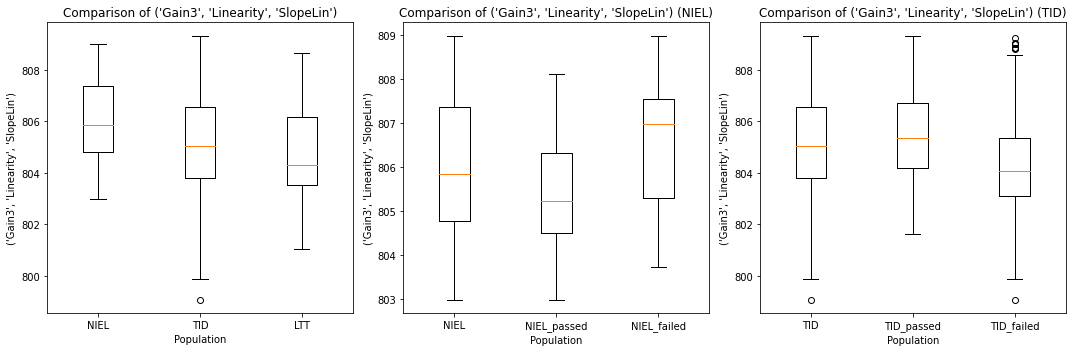

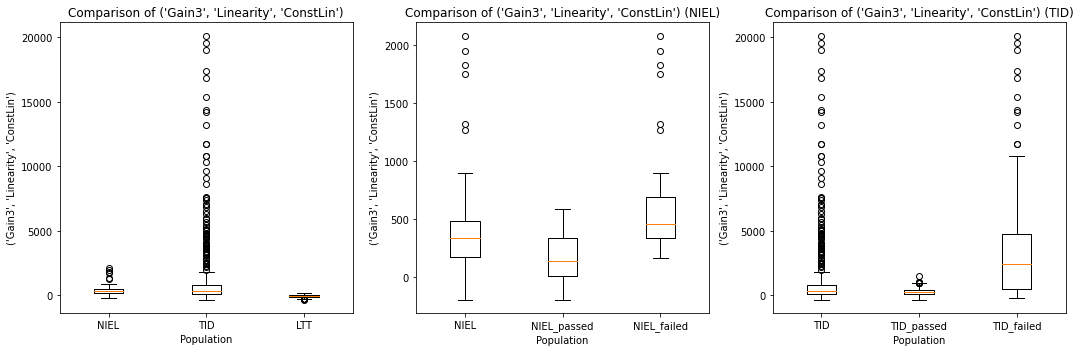

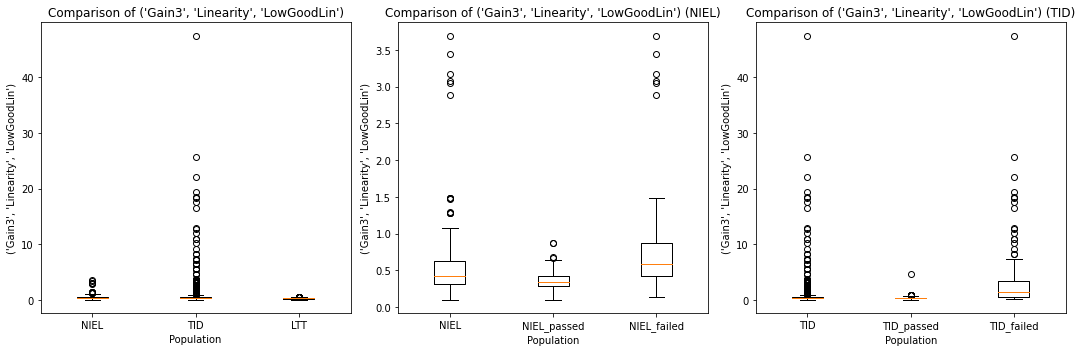

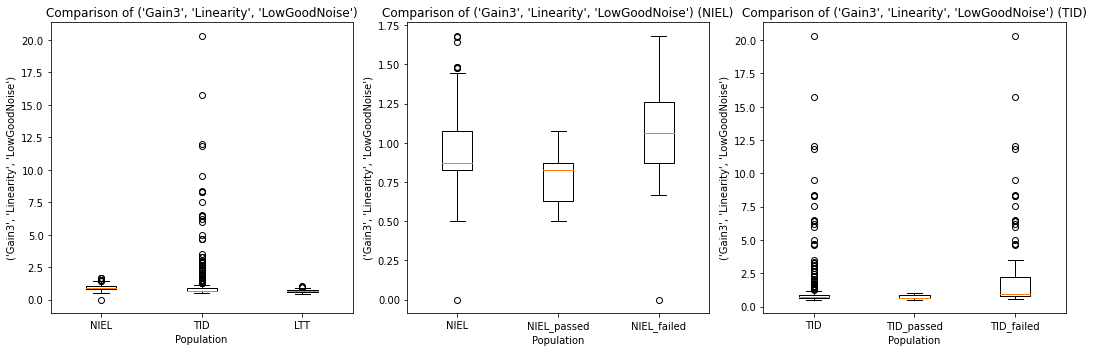

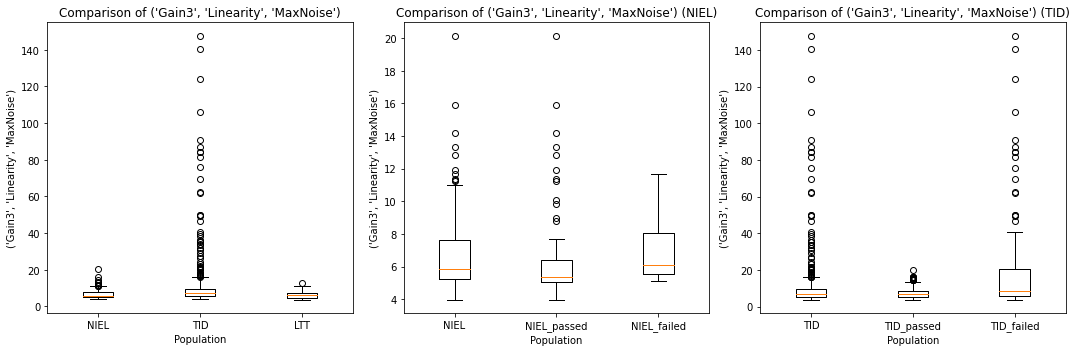

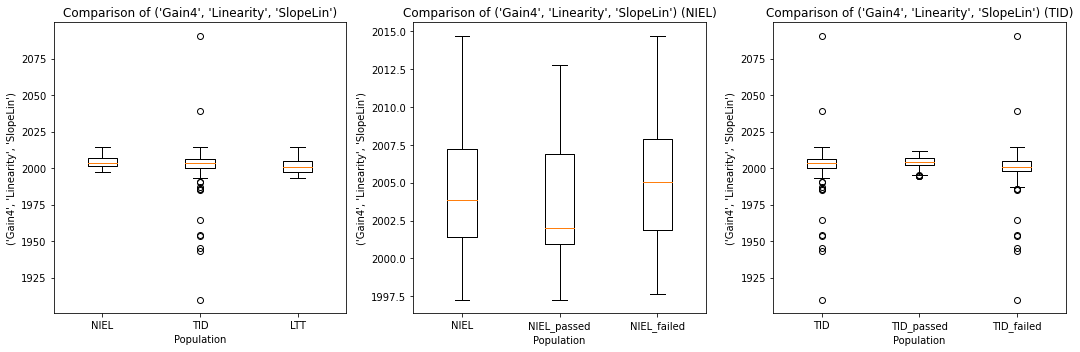

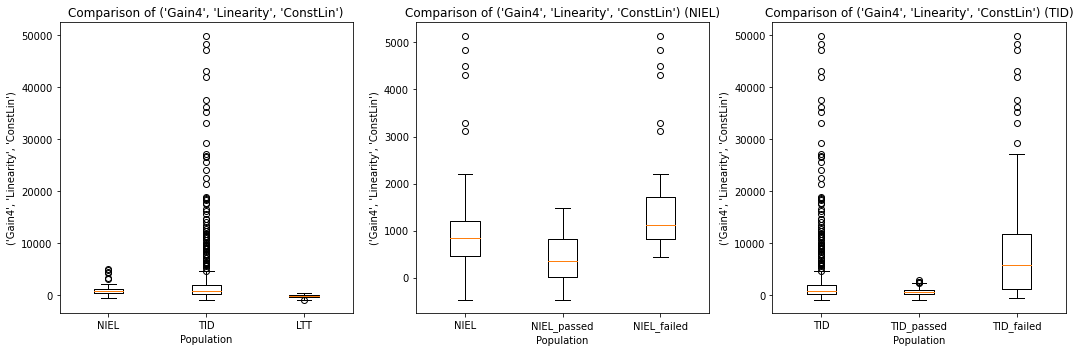

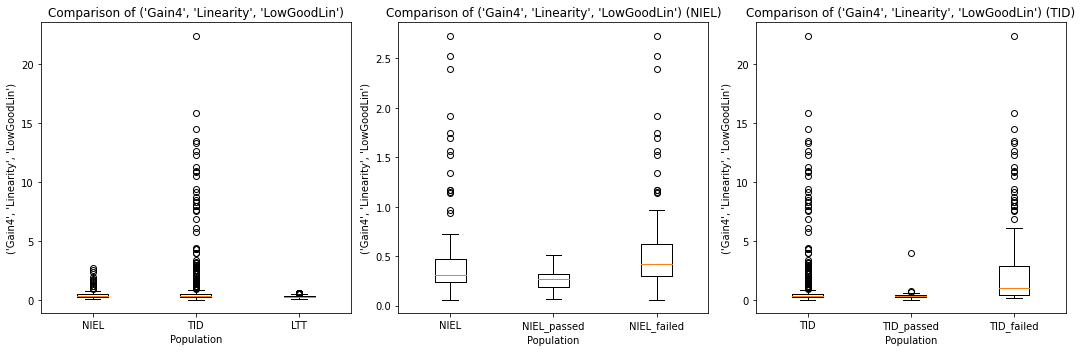

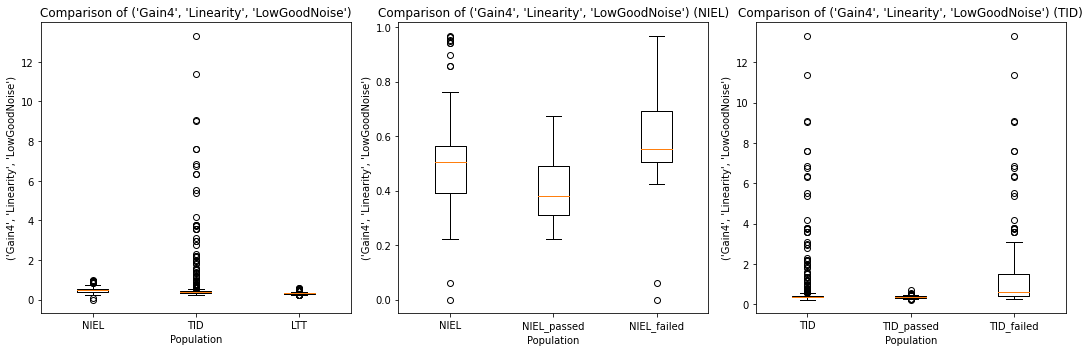

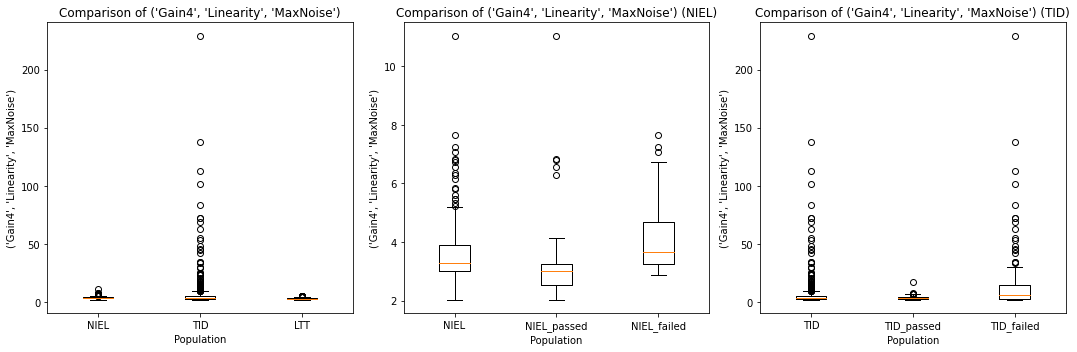

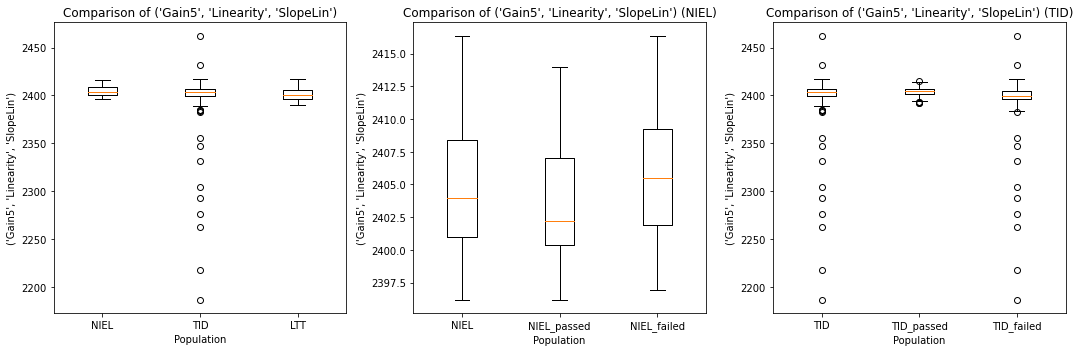

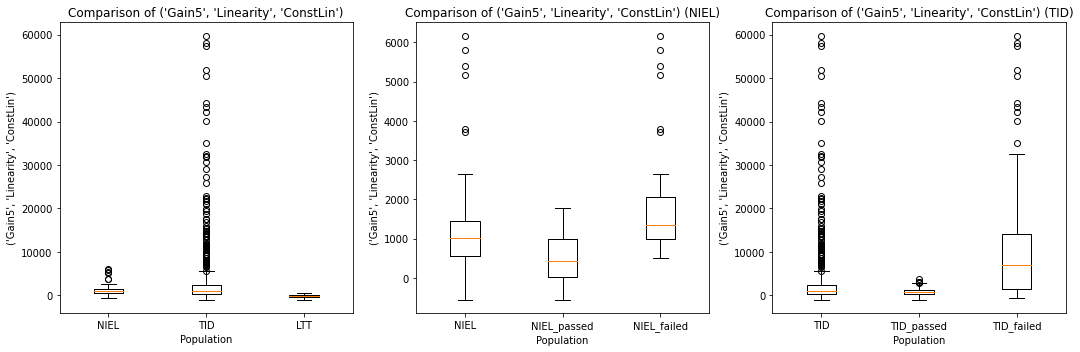

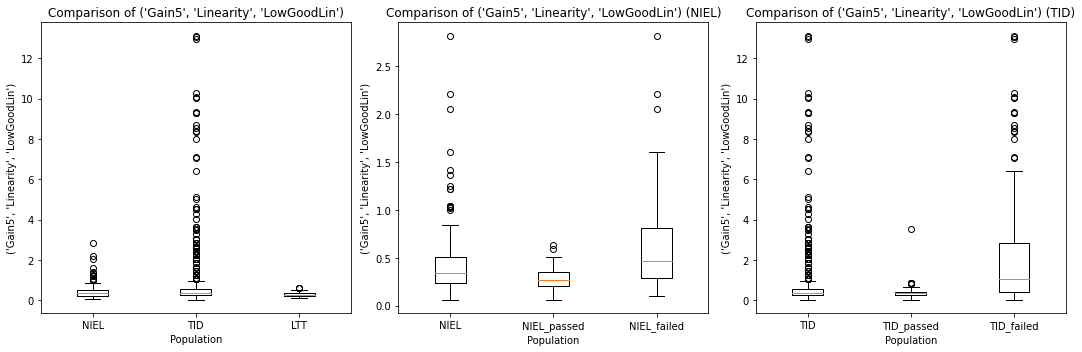

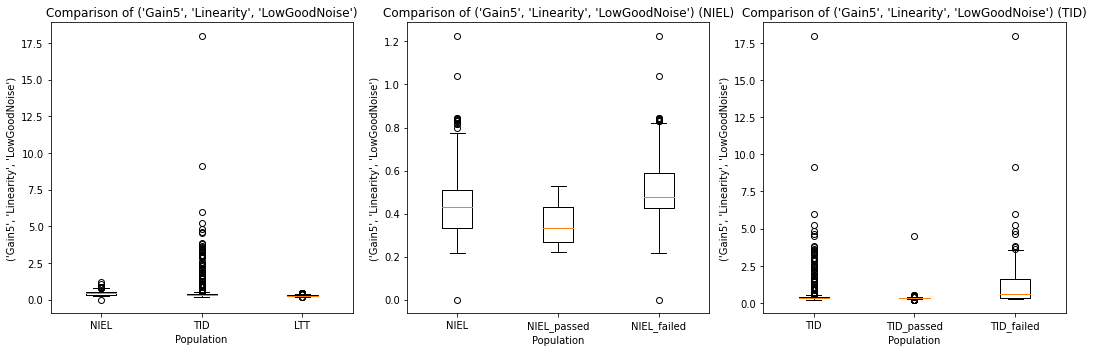

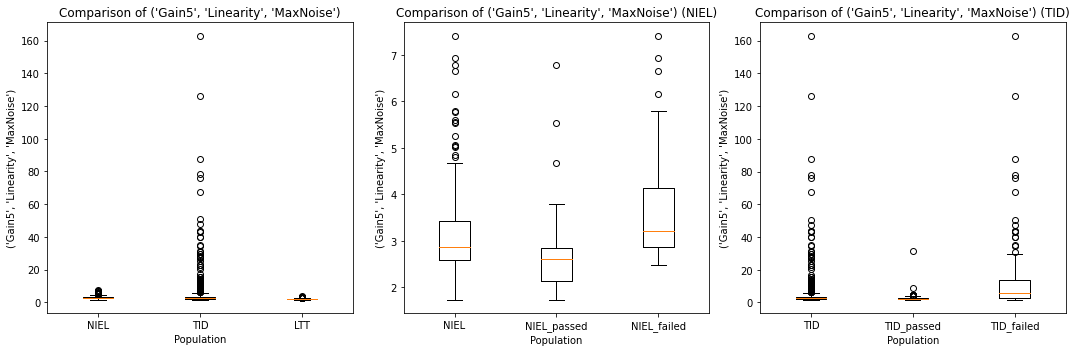

In [31]:
import matplotlib.pyplot as plt

# Create a list of the three populations
all_populations = [NIEL, TID, LTT]

NIEL_populations = [NIEL, NIEL_passed, NIEL_failed]

TID_populations = [TID, TID_passed, TID_failed]

# Create a list of labels for the x-axis
labelsAll = ['NIEL', 'TID', 'LTT']

labelsNiel = ['NIEL', 'NIEL_passed', 'NIEL_failed']

labelsTID = ['TID', 'TID_passed', 'TID_failed']

# Iterate over each feature and create a box plot for each
for feature in Slow2_filtred.columns:
    # Create a figure and axis for each feature
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Create a list of data for each population
    data_all = [population[feature] for population in all_populations]
    data_NIEL = [population[feature] for population in NIEL_populations]
    data_TID = [population[feature] for population in TID_populations]
    
    # Create the box plots for all populations
    ax1.boxplot(data_all)
    ax1.set_xticklabels(labelsAll)
    ax1.set_title(f'Comparison of {feature}')
    ax1.set_xlabel('Population')
    ax1.set_ylabel(f'{feature}')
    
    # Create the box plots for NIEL populations
    ax2.boxplot(data_NIEL)
    ax2.set_xticks([1, 2, 3])  # Set the tick positions directly
    ax2.set_xticklabels(labelsNiel)  # Set the tick labels for NIEL populations
    ax2.set_title(f'Comparison of {feature} (NIEL)')
    ax2.set_xlabel('Population')
    ax2.set_ylabel(f'{feature}')
    
    # Create the box plots for TID populations
    ax3.boxplot(data_TID)
    ax3.set_xticks([1, 2, 3])  # Set the tick positions directly
    ax3.set_xticklabels(labelsTID)  # Set the tick labels for TID populations
    ax3.set_title(f'Comparison of {feature} (TID)')
    ax3.set_xlabel('Population')
    ax3.set_ylabel(f'{feature}')
    
    # Adjust the spacing between subplots
    plt.tight_layout()
    
    # Display the plot
    plt.show()



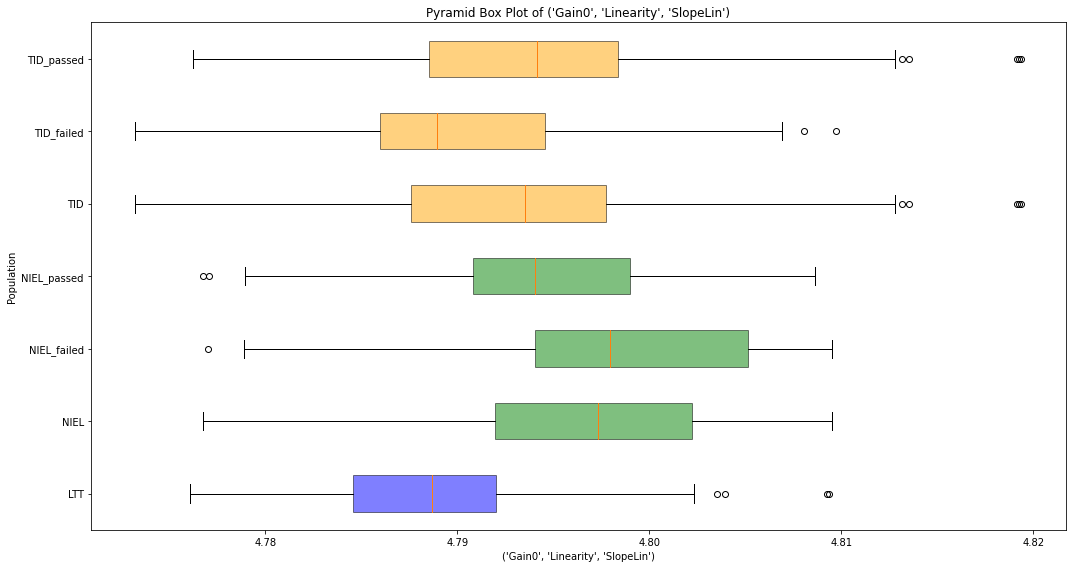

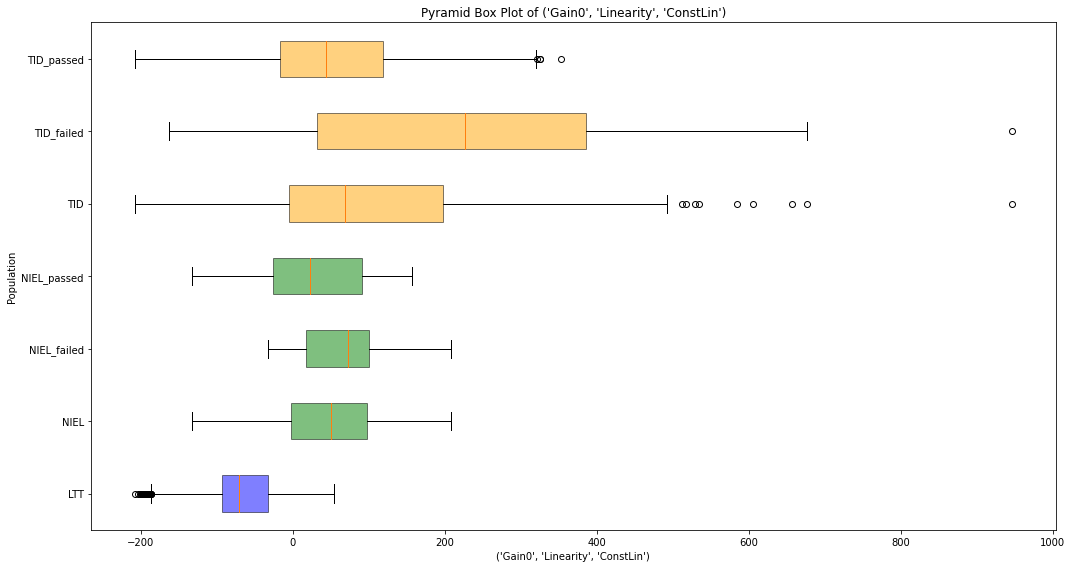

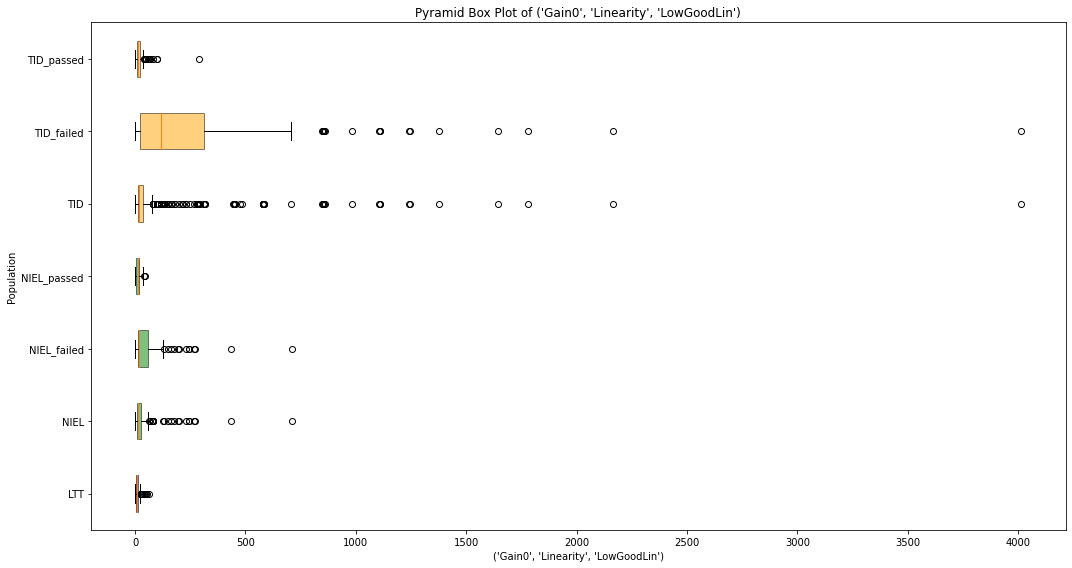

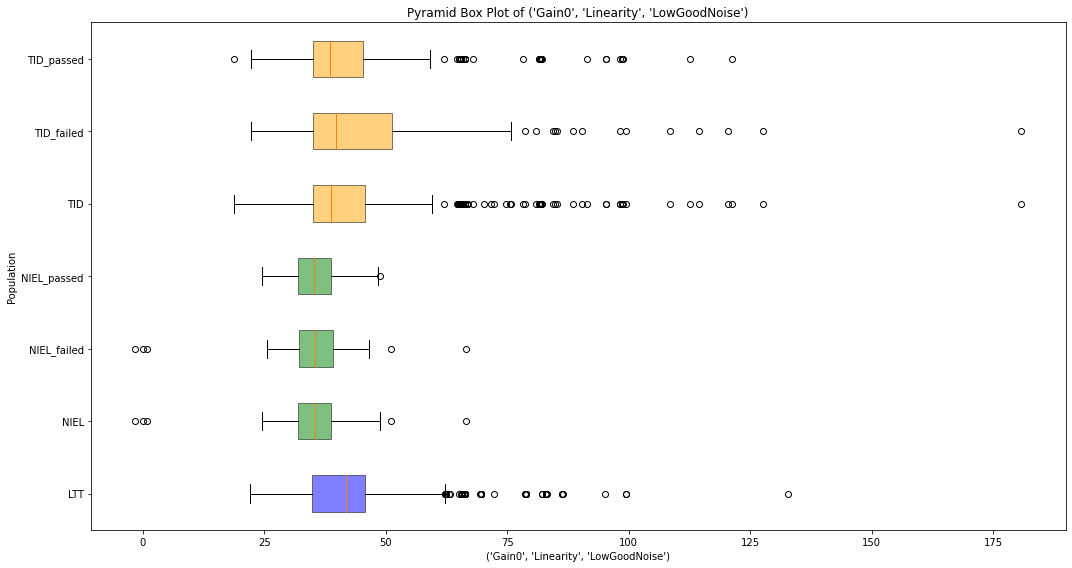

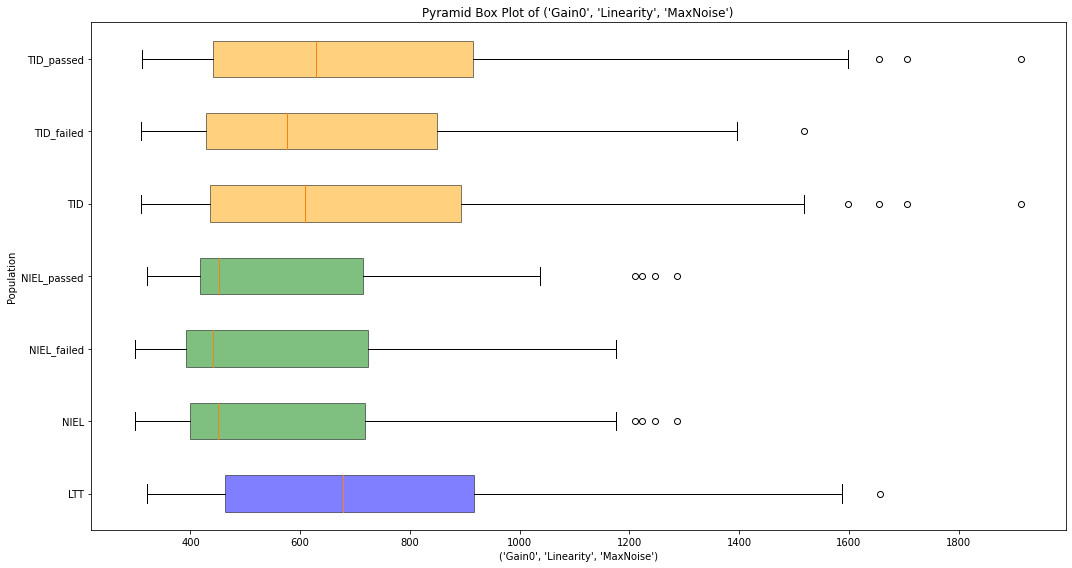

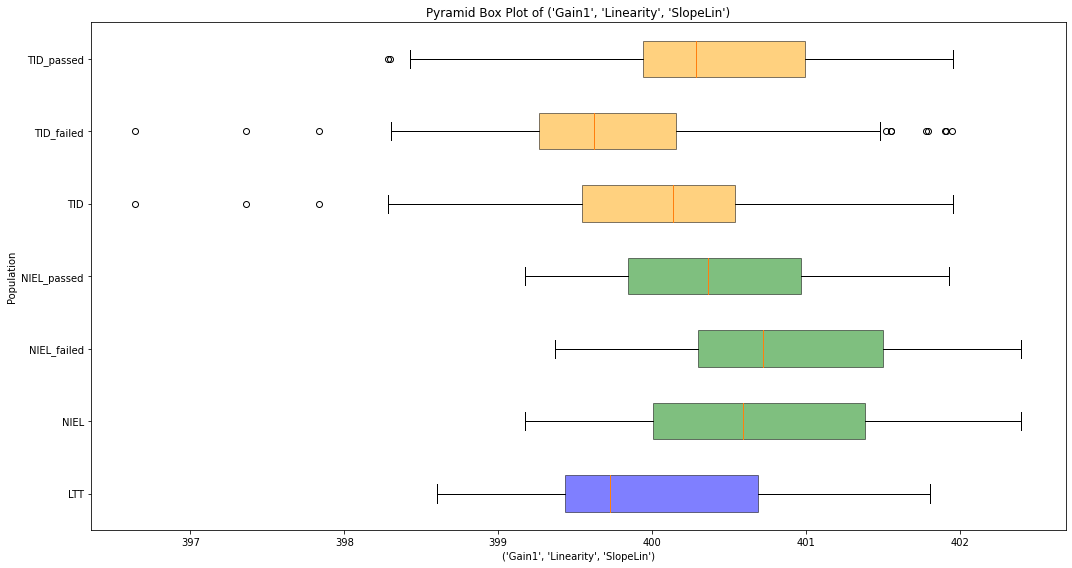

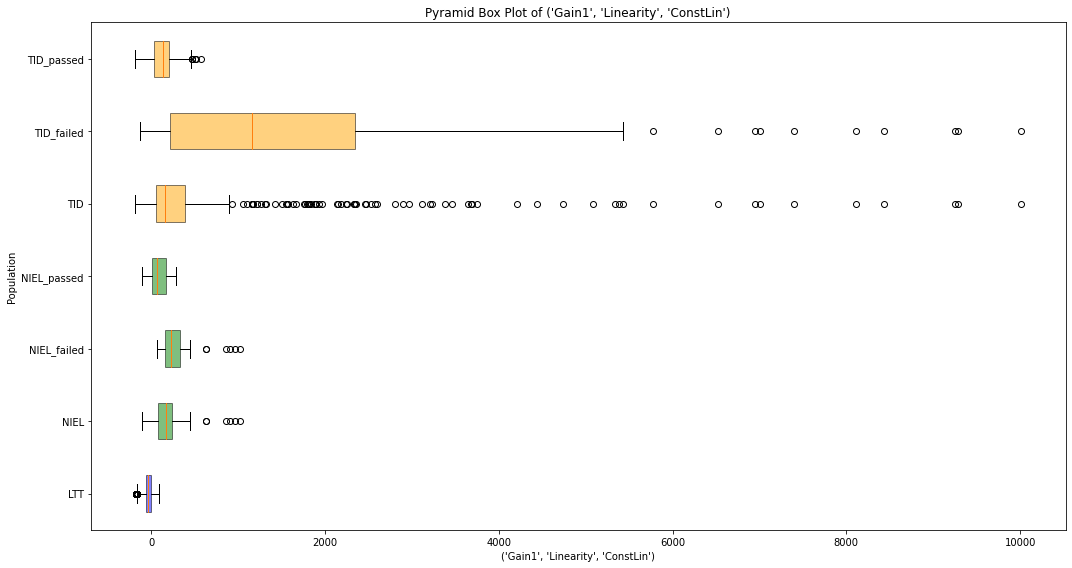

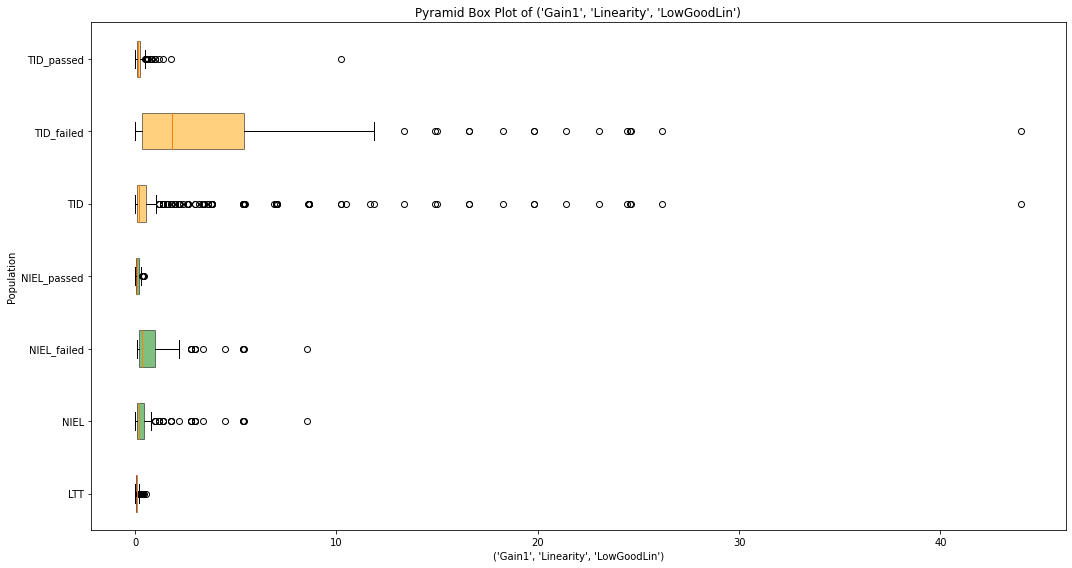

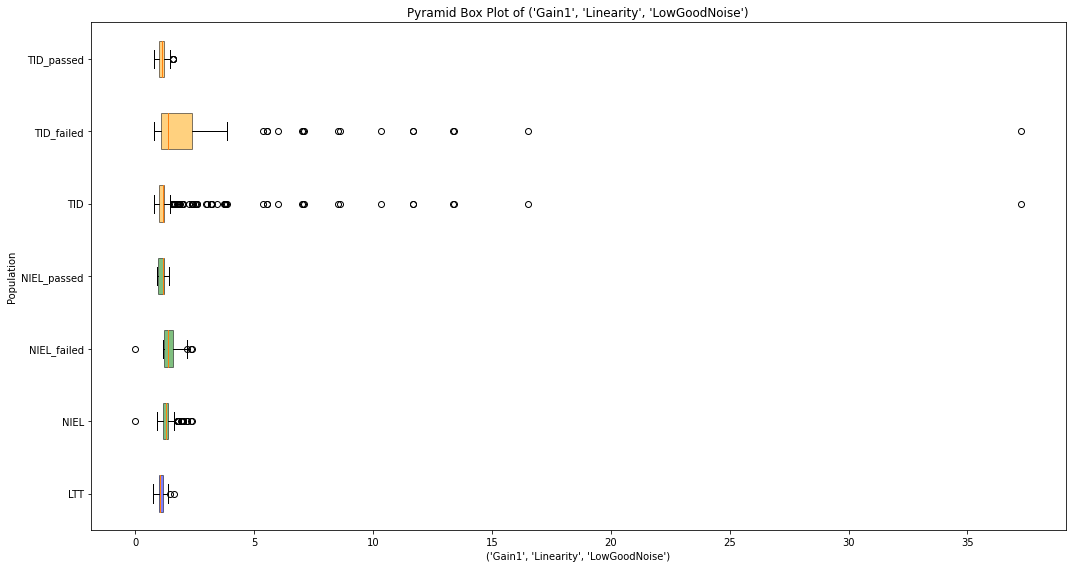

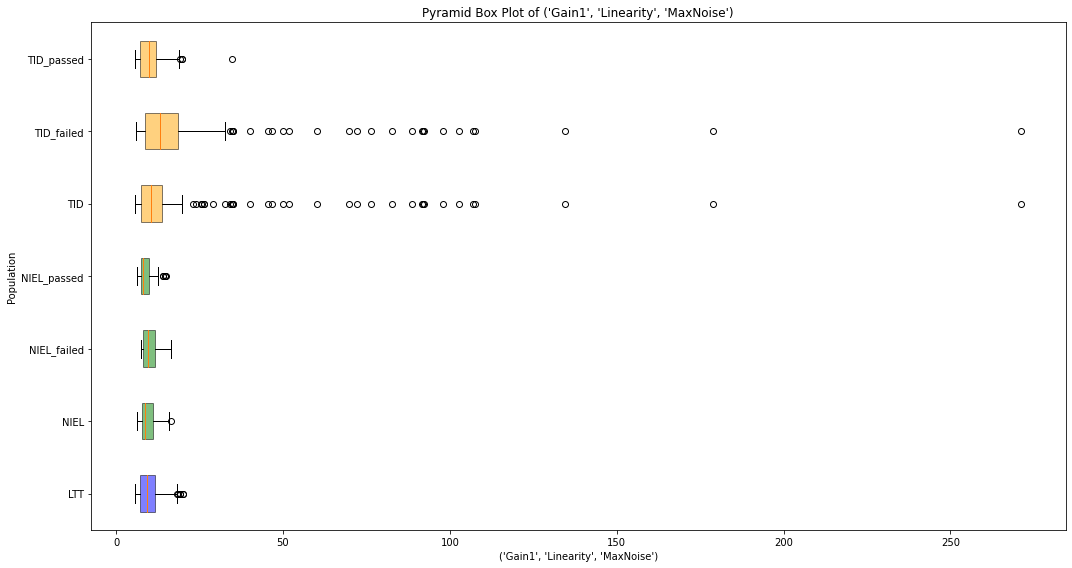

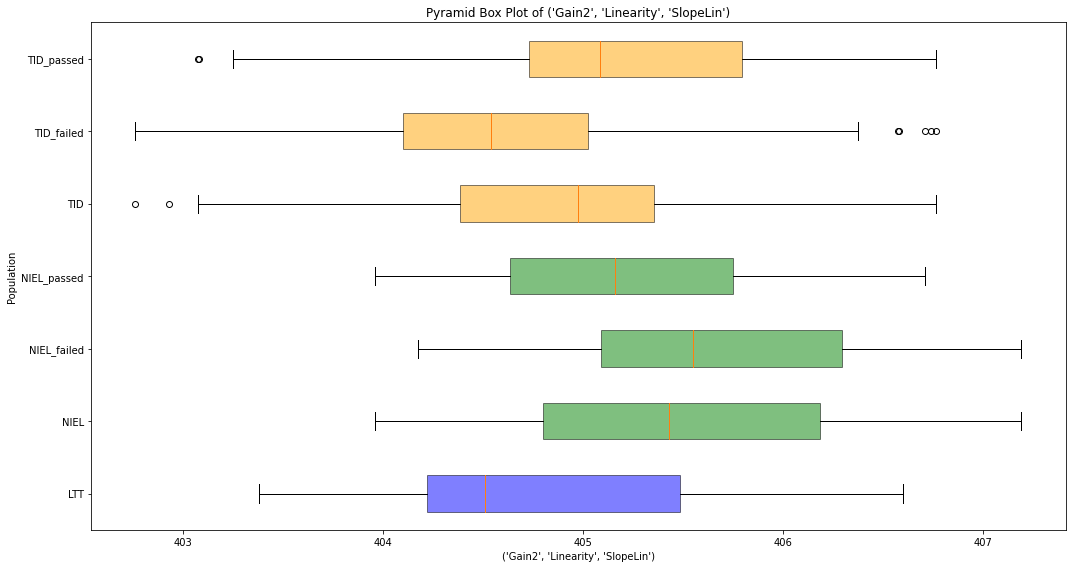

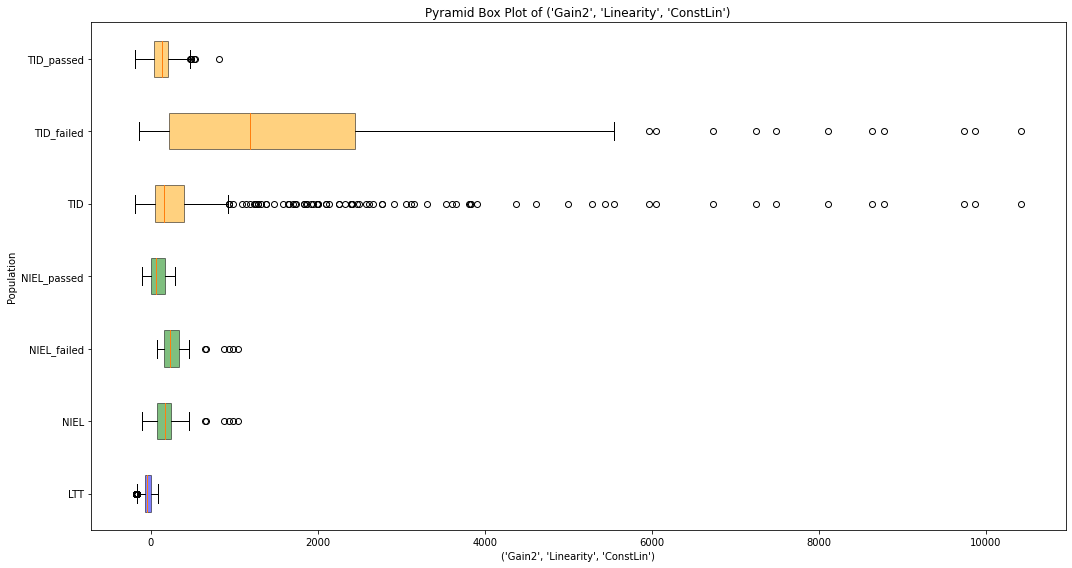

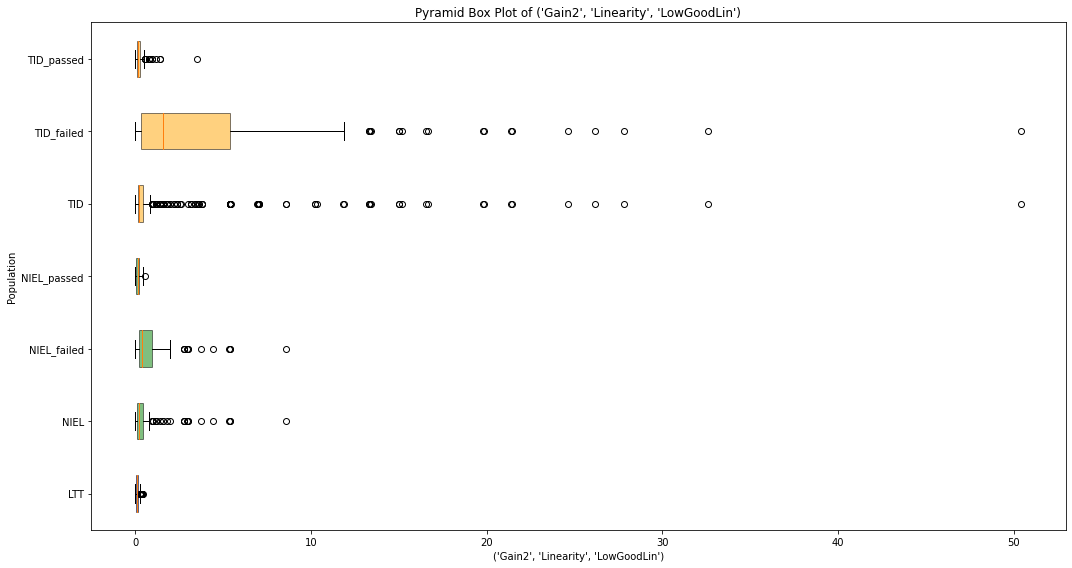

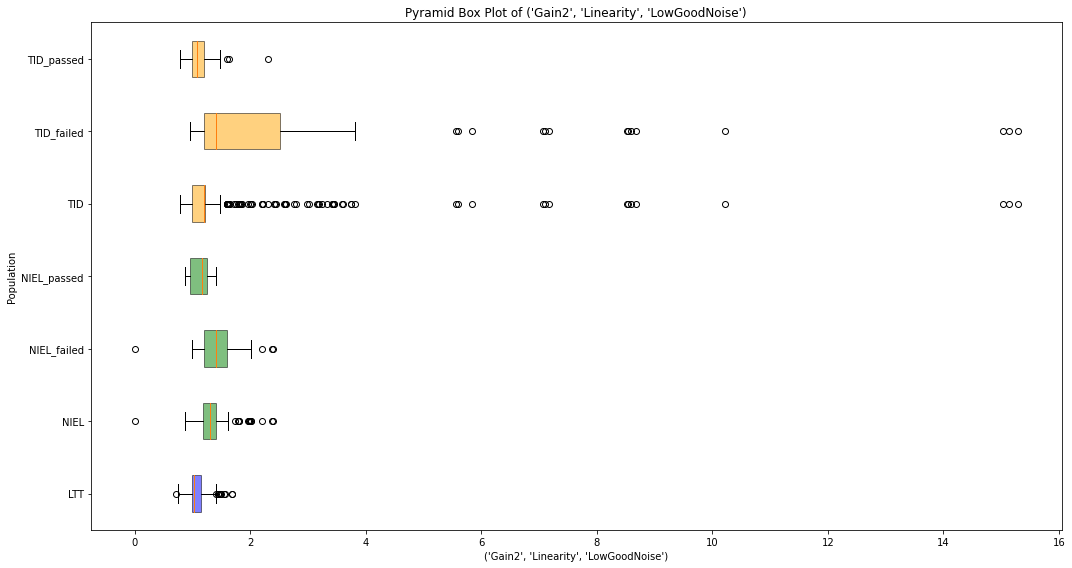

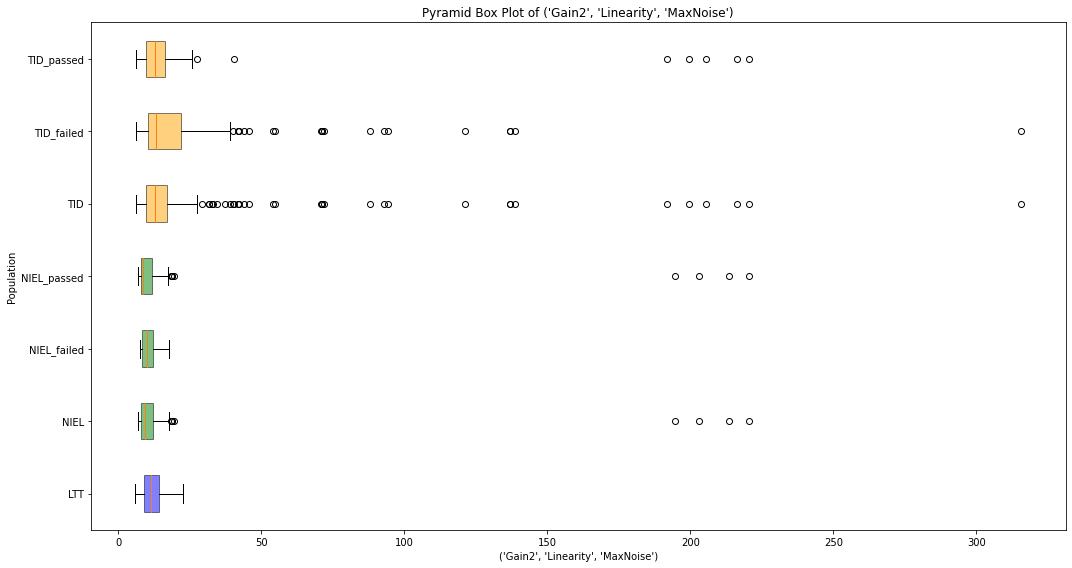

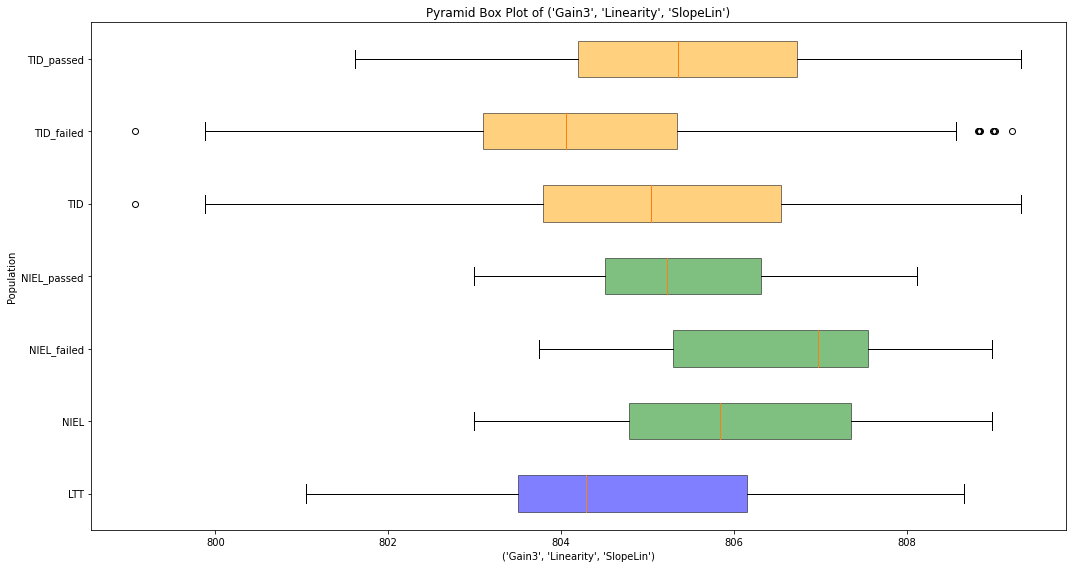

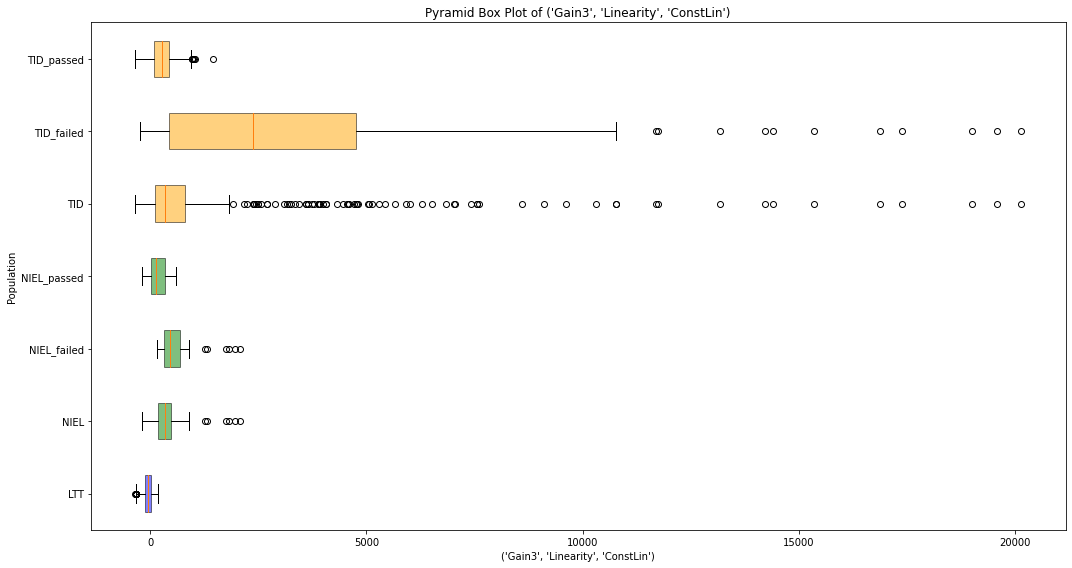

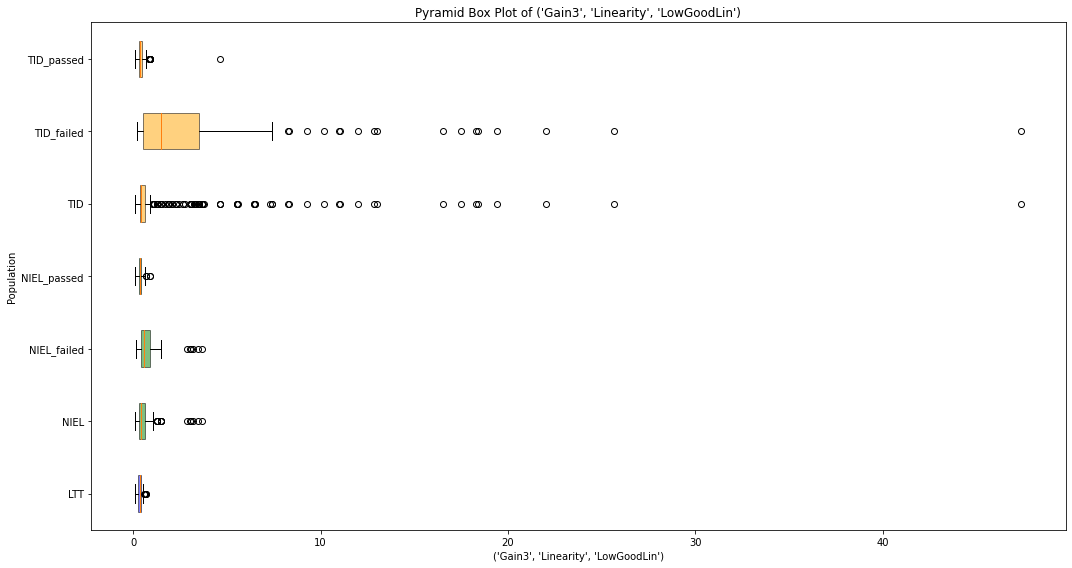

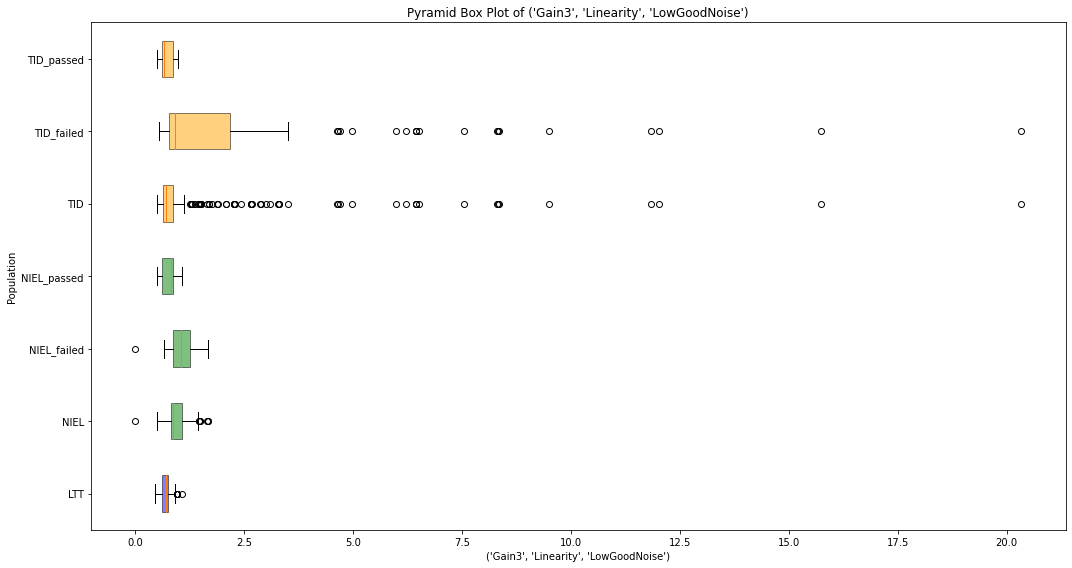

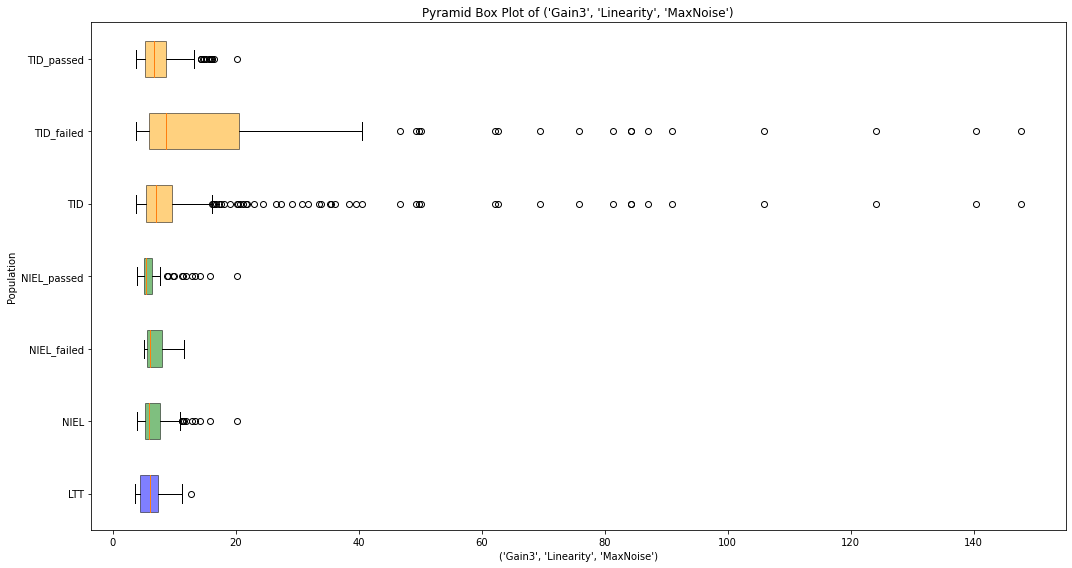

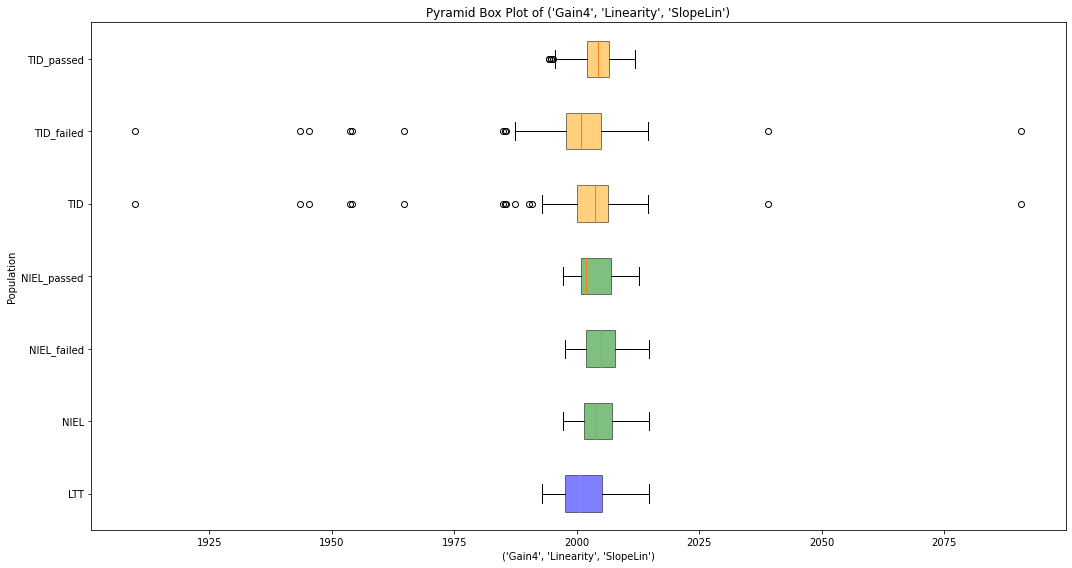

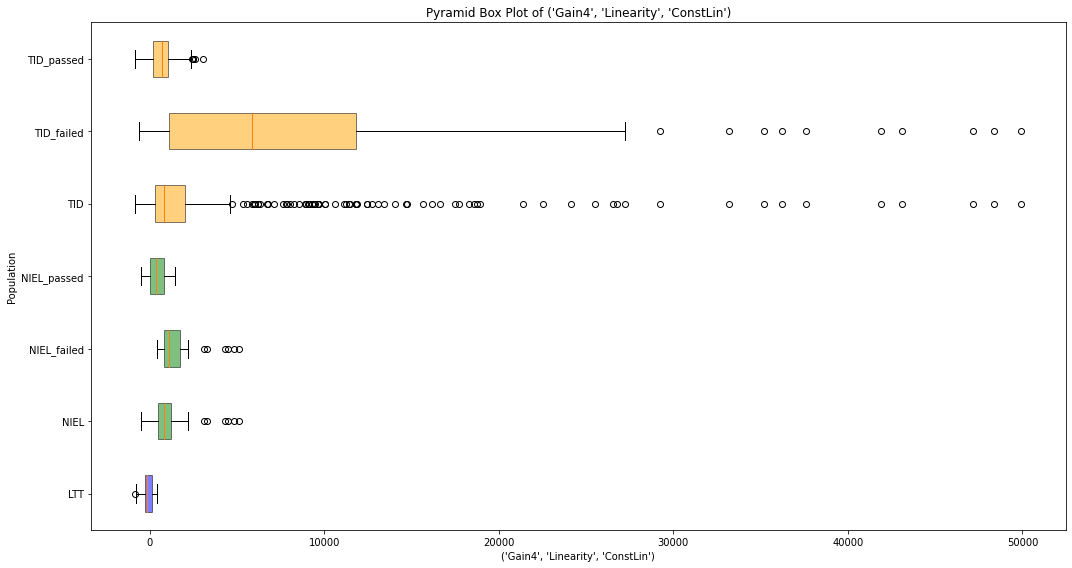

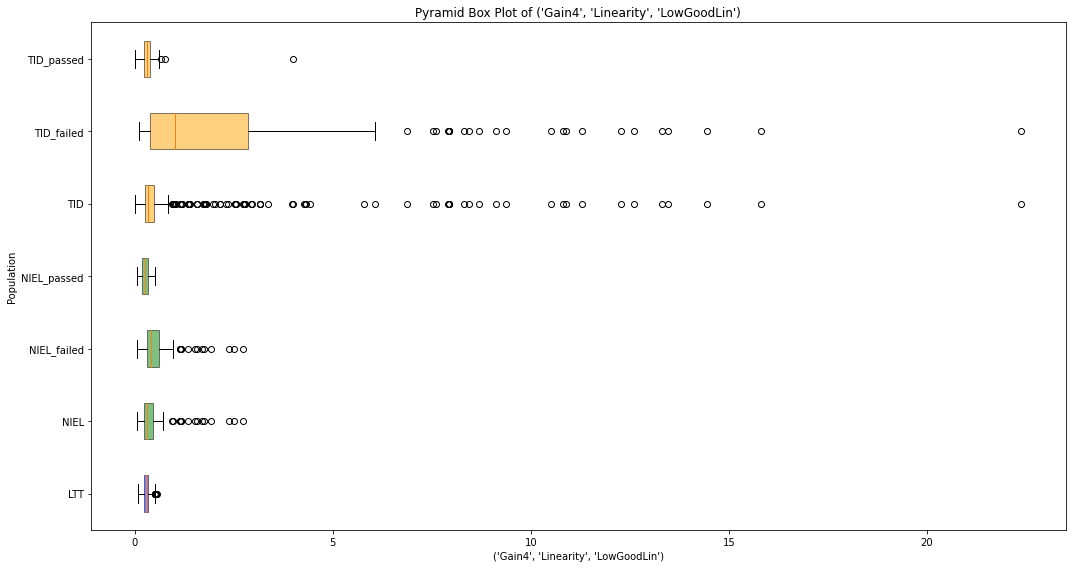

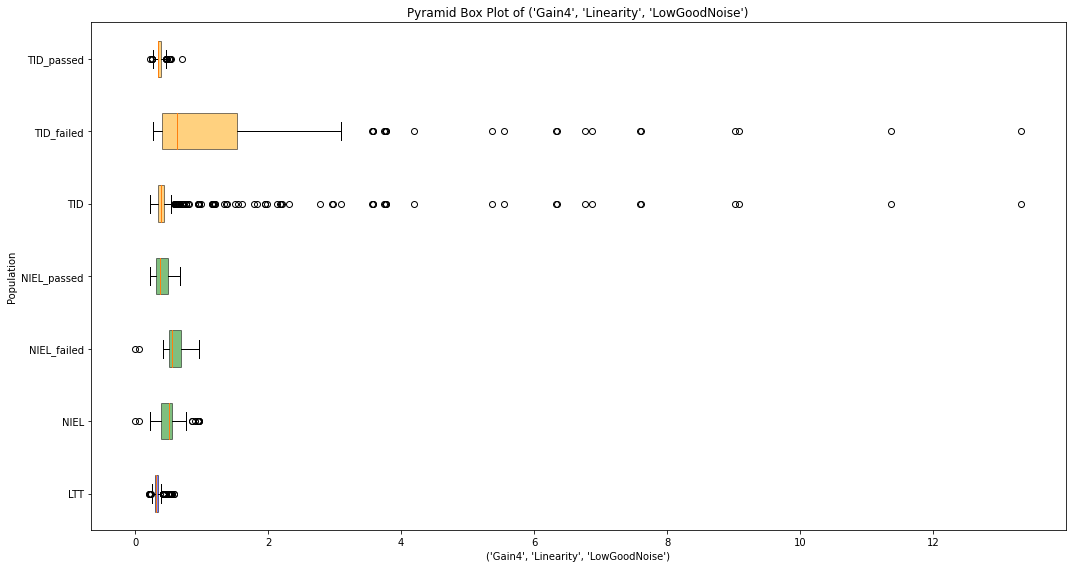

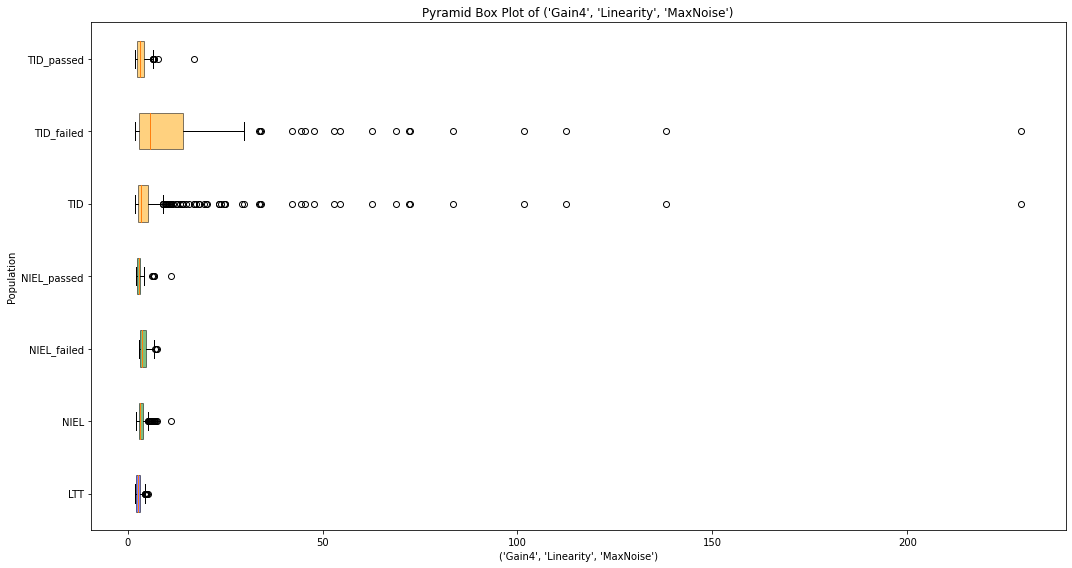

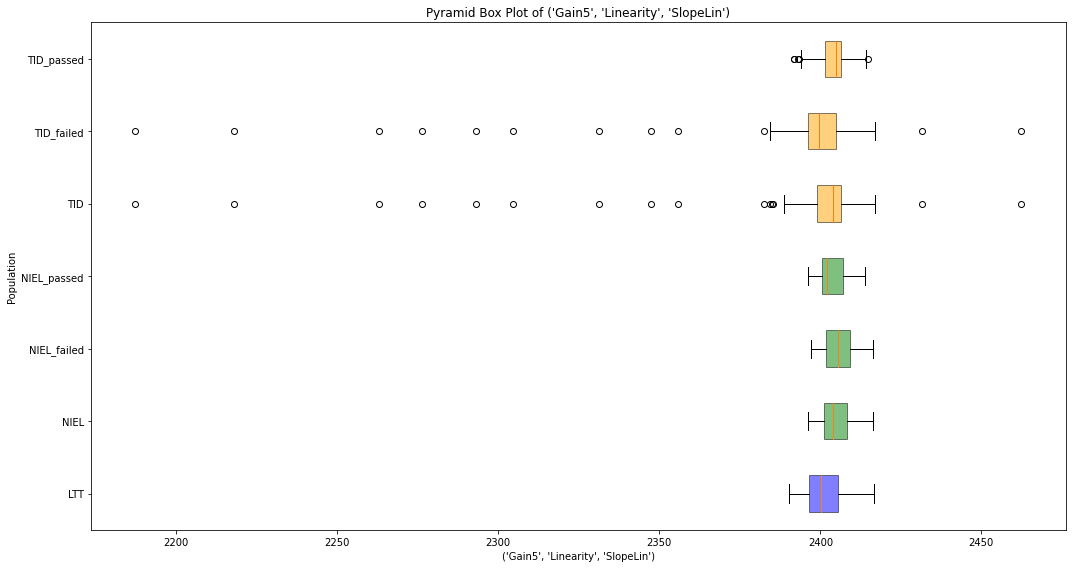

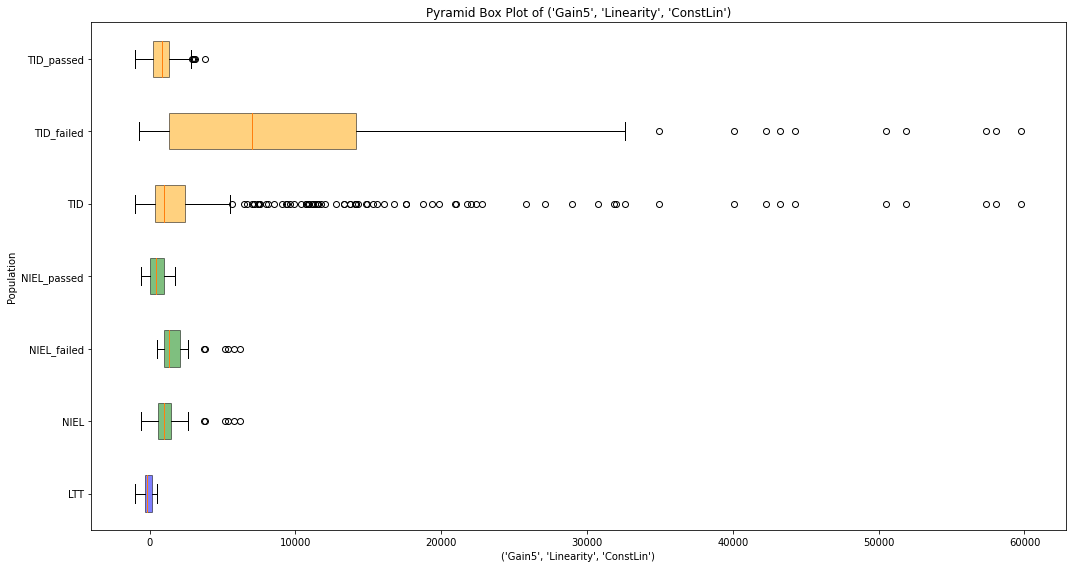

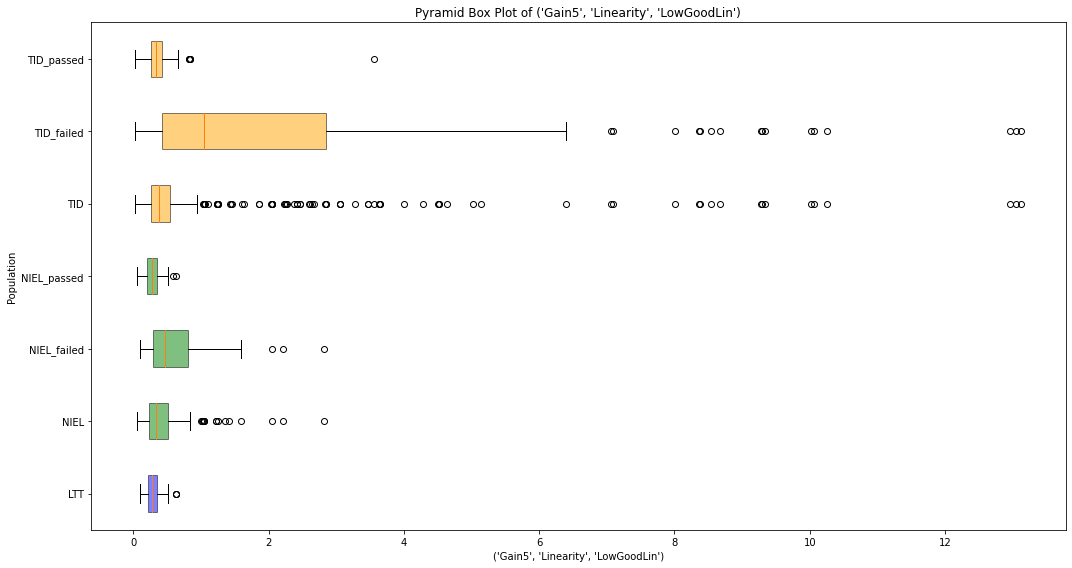

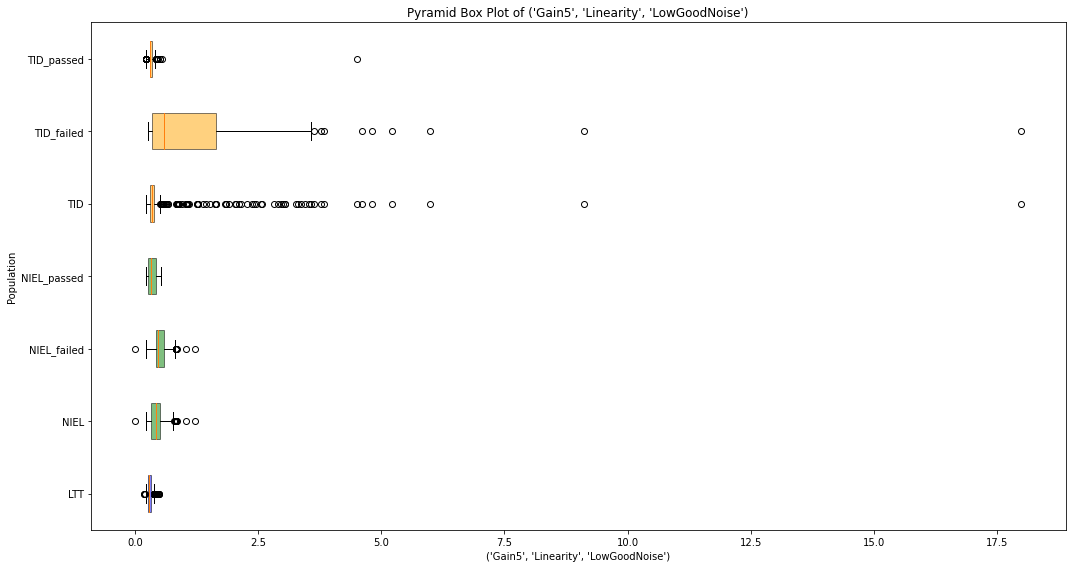

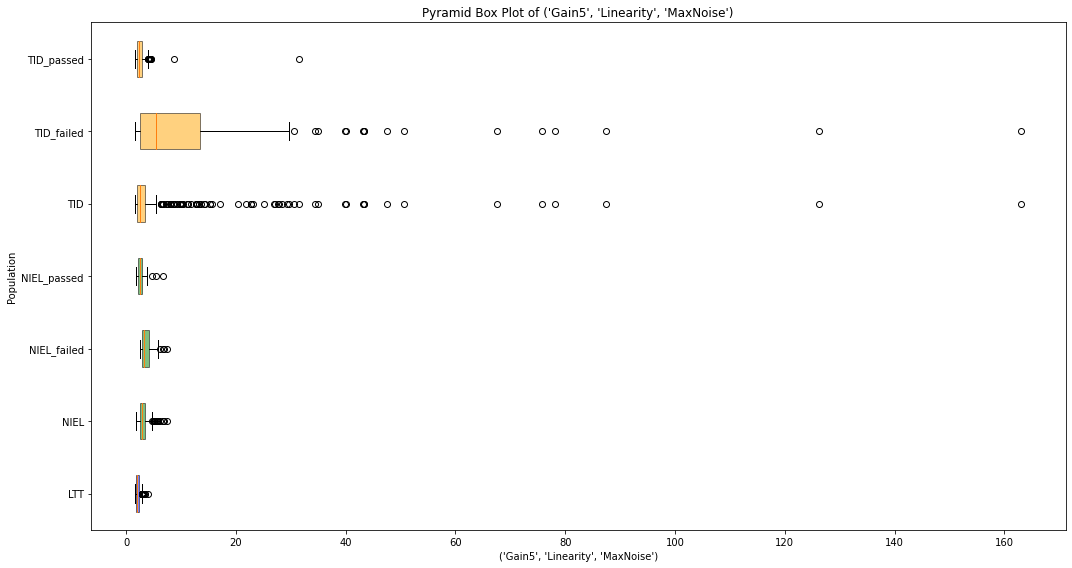

In [32]:
import matplotlib.pyplot as plt

# Create a list of the populations
populations = [LTT, NIEL, NIEL_failed, NIEL_passed, TID, TID_failed, TID_passed]

# Create a list of labels for the y-axis
labels = ['LTT', 'NIEL', 'NIEL_failed', 'NIEL_passed', 'TID', 'TID_failed', 'TID_passed']

# Create a list of colors for the boxes
colors = ['blue', 'green', 'green', 'green', 'orange', 'orange', 'orange']

# Calculate the positions for the boxes
positions = list(range(1, len(populations) + 1))

# Iterate over each feature and create the pyramid box plot
for feature in Slow2_filtred.columns:
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(15,8))
    
    # Create a list of data for each population
    data = [population[feature] for population in populations]
    
    # Create the box plot with custom colors
    boxes = ax.boxplot(data, vert=False, positions=positions, patch_artist=True)
    
    # Set the facecolor of each box
    for patch, color in zip(boxes['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5) 
    # Set the y-axis labels
    ax.set_yticks(positions)
    ax.set_yticklabels(labels)
    
    # Set the title and labels for the plot
    ax.set_title(f'Pyramid Box Plot of {feature}')
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('Population')
    
    # Adjust the spacing
    plt.tight_layout()
    
    # Display the plot
    plt.show()


In [34]:
custom_filter = [('Checkbox',dict(radio_categories=[dict(name = 'LTT',indexes=['LTT']),
                                dict(name = 'NIEL',indexes=['NIEL']),
                                dict(name = 'NIEL_passed',indexes=['NIEL_passed']),
                                dict(name = 'NIEL_failed',indexes=['NIEL_failed']),
                                dict(name = 'TID',indexes=['TID']),
                                dict(name = 'TID_passed',indexes=['TID_passed']),
                                dict(name = 'TID_failed',indexes=['TID_failed']),
                                ])),('Slider')]



for progress,feature in enumerate(allpopulations.columns[:-2]):
    plot = FATL.FenBokehGrapher(allpopulations['Population_id'],allpopulations[feature],
                                FENICS2.Board.id.iloc[allpopulations.index],
                                allpopulations['Population'],
                                colors=FENICS2.Board.burnTime.iloc[allpopulations.index],labels=allpopulations['Population'],tooltips=[("FENICS","@id"),("Population","@Population")])
    plot.plotter(plotType='histogram',filters=custom_filter,title=f'{feature}',showGraph=False)
    plot.save_as_html(path='/users/divers/atlas/sisaid/home2/fen2_output_comparaison/jitter/',filename=f'{feature}_dataSpread')
    FATL.loadingBar(progress,len(allpopulations.columns[:-2]),suffix=str(feature))


|                                                  | progress: 100%                                                                                   DONE 
